In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import numpy as np 
import pickle
import glob 
import os 
import time , sys
from scipy import integrate
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D

from functions import read_dat2file

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/'
metallicity='mw'
file_ext= '.dat2'




In [96]:
# sort file names so that they are listed by mass, then rotation velocity 
m_val=lambda x : int(x.split('/')[-1].split('.')[0].split('-')[0][1:])
v_val= lambda x : int(x.split('/')[-1].split('.')[0].split('-')[1])

s1=sorted(glob.glob(data_dir +'*'+ file_ext), key=v_val)
data_files=sorted(s1, key= m_val)


#cut stars heavier than 40M, at they do not contribute to Be
data_files=filter(lambda x: m_val(x) < 40, data_files)
#print data_files

mass_list=[]
for f in data_files:
    mass_list=np.append(mass_list, int(m_val(f)))
    
mass_list=np.unique(mass_list)



print 'masses of models :\n',mass_list


masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35.]


# find mass bins # 

In [97]:
#mass_list=[3,5,7, 9,10, 12, 15, 20, 25, 30,40, 50, 60, 80, 100 ] # list of model masses


###################################3
#make bins from mass list############
####################################

#duplicate list with a shift 
ml2=np.insert(mass_list, 0, 0)# mass_list.insert(0,0)
#print mass_list, ml2

bins=[]

for u,v in zip(mass_list, ml2):
    
    bins += [0.5*(u-v) + v]

#add last bin manually     
bins = np.append(bins,mass_list[-1])
# add first bin manually
np.put(bins, 0, mass_list[0])

print 'masses of models ', mass_list    
print 'mass bins ',bins

masses of models  [ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35.]
mass bins  [ 3.   4.   6.   8.   9.5 11.  13.5 17.5 22.5 27.5 32.5 35. ]


# define IMF #

In [98]:
def imf(m,alpha, eta0):
    """power law imf with power -alpha, constant eta0.
    m is input masses"""
    return eta0 * m**(-alpha)


def CDF_imf(lower, upper, alpha, eta0):
    """Cumlative distribution function from power law imf with power -alpha, constant eta0.
    m is input masses. integral of imf"""
    a= -alpha +1
    
    if lower == 0 :
        
        return -(eta0 /a * upper**a)
    
    
    else:
        int_upper=  (eta0/ a) * upper**a
        int_lower= (eta0/ a) *lower**a
        integ_result= int_upper - int_lower
    
        return integ_result
    

In [99]:

#check that total CDF between mass limits is 1. If not eta0 value needs to be tweaked! 
eta0=1/0.17685188743510563
print "integral of IMF between ", bins[0],'and', bins[-1], 'eta0 = ', eta0
print CDF_imf(bins[0], bins[-1], 2.3,eta0)


integral of IMF between  3.0 and 35.0 eta0 =  5.65444912408
0.9999999999999998


# calculate mass distribution #

In [100]:
#duplicate list with a shift 
b2 = list(bins)
b2.pop(0)

mass_dist={}

#print "m1, m2, p(m1 < m < m2):"
for b,a, m  in zip(bins, b2, mass_list): 
    #print b,a,CDF_imf(b, a, 2.3, 2.21306)
    mass_dist[m] = CDF_imf(b, a, 2.3, eta0)
    
    
#print mass_dist
a=0
for key in sorted(mass_dist):
    print "%s: %s" % (key, mass_dist[key])
    a+=mass_dist[key]
    
print "sum=", a

3.0: 0.3253593612082901
5.0: 0.293915548443137
7.0: 0.13213696040918388
9.0: 0.05833301538877583
10.0: 0.0404358011641916
12.0: 0.04501612073829522
15.0: 0.04225832865389363
20.0: 0.029352435310709107
25.0: 0.01744295868665635
30.0: 0.011423786319440458
35.0: 0.004325683677426528
sum= 0.9999999999999998


## plot mass distribution ##

3.0 4.0 0.3253593612082901
4.0 6.0 0.293915548443137
6.0 8.0 0.13213696040918388
8.0 9.5 0.05833301538877583
9.5 11.0 0.0404358011641916
11.0 13.5 0.04501612073829522
13.5 17.5 0.04225832865389363
17.5 22.5 0.029352435310709107
22.5 27.5 0.01744295868665635
27.5 32.5 0.011423786319440458
32.5 35.0 0.004325683677426528


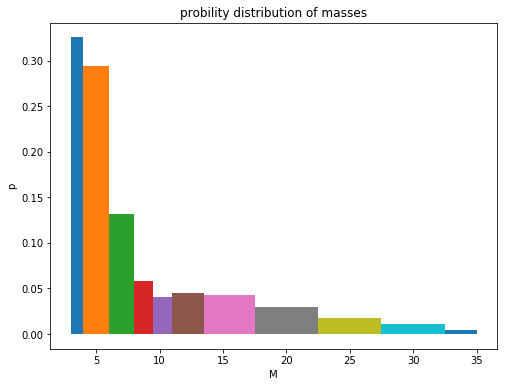

In [101]:
#print mass_dist.values()
for b,a, m  in zip(bins, b2, mass_list): 
    p=CDF_imf(b, a, 2.3, eta0)
    print b,a,p
    x=[b,a,a,b]
    y=[0,0, p,p]
    
    plt.fill(x,y)
    
plt.title ("probility distribution of masses")
plt.ylabel("p")
plt.xlabel("M")
plt.show()

# rotation distribution #

In [102]:


def integrate_vdist(lower, upper):
    # vdistribution as found earlier in polynomial form
    v_dist=np.poly1d([ 4.96085349e-13, -4.27023037e-10,  6.65435944e-08,  6.46442910e-06
  ,1.93953157e-03])
    # max value of v that polynomial takes. for values greater than v, pdf is 0 
    v_max_val=430
    
    if lower  > v_max_val:
        return 0
    
    if upper > v_max_val:
        upper= v_max_val
        
    int_func=np.polyint(v_dist)
     
    return int_func(upper) -int_func(lower)



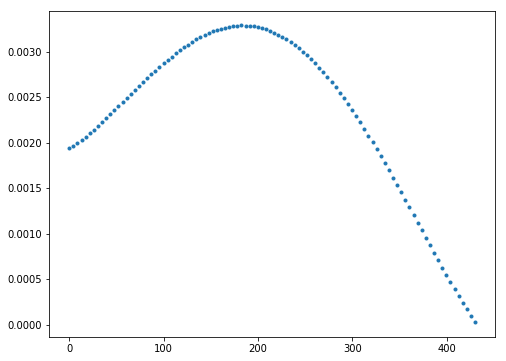

1.0040032956173732


In [103]:
# load in  rot distributoon
v_dist=np.poly1d([ 4.96085349e-13, -4.27023037e-10,  6.65435944e-08,  6.46442910e-06
  ,1.93953157e-03])
plt.plot(np.linspace(0,430,100), v_dist(np.linspace(0,430,100)), '.')
plt.show()

#b=0#mass_group.iloc[i].lower_bin
#a=400#mass_group.iloc[i].upper_bin
#x=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'v' ]
#y=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'pdf' ]
print integrate_vdist(0,430)


# define rotation bins # 

In [10]:
#rot_bins={}

#for m in mass_list: 
#    f_list=[]
#    for f in data_files:
#        if ('f' +str(m)+'-') in f:
#            #print f,
#            f_list.append(f)#

#    for i in range(0, len(f_list)):
#        f=f_list[i]
#        m=m_val(f)
#        v=v_val(f)
#        if (i < len(f_list)-1) and i > 0:
#            fp1=f_list[i+1]
#            fm1=f_list[i-1]
#            u_bin= float((v_val(fp1) - v_val(f))  ) *0.5 +  v_val(f)
#            l_bin= float((v_val(fm1) - v_val(f))  ) *0.5 +  v_val(f)3

#        if i ==0 : # for 1st file
#            fp1=f_list[i+1]
#            u_bin= float((v_val(fp1) - v_val(f))  ) *0.5 +  v_val(f)
#            l_bin= 0

#        if (i ==len(f_list)-1) : # for last file
#            fm1=f_list[i-1]
#            u_bin= v_val(f)
#            l_bin= float((v_val(fm1) - v_val(f))  ) *0.5 +  v_val(f)

#        rot_bins[m,v] = [l_bin, u_bin]


#for k in sorted(rot_bins.keys()):
    #print k, rot_bins[k]
    
Be_fracdf=pd.DataFrame(columns=['t/s', 'Be_frac'])
Be_fracdf.append(pd.DataFrame([[23,1]],columns=['t/s', 'Be_frac'] ))

,t/s,Be_frac
0,23.0,1.0


In [261]:
t_val= 1 # in s
Be_value=0.7
Be_fracdf=pd.DataFrame(columns=['t/s', 'Be_frac'])
rot_df= pd.DataFrame(columns=['M', 'V', 'V_act', 'V_crit'])
for f in data_files: 
    df,_=read_dat2file(f)
    
    #FIND MS MODELS. based on gradient of surface He fraction with time. MS is until 1st dredge up 
    y=np.array(df['27:He_massfr'])
    t=np.array(df['1:t[s]'])
    dydt= np.gradient(y, t)
    df=df[df['1:t[s]'] < t[np.nanargmax(dydt)]] 
    
    # add models with time nearest to time value to new dataframe
    # check that nearest model is still MS
    T=df['1:t[s]'].loc[(df['1:t[s]']-t_val).abs().argmin()]
    if df['1:t[s]'].max() > t_val:
        v_act= df['9:v_surf[km/s]'].loc[T]
        v_crit=  df['8:v_crit[km/s]'].loc[T]
        d=pd.DataFrame([[m_val(f), v_val(f), v_act, v_crit]], columns=['M', 'V', 'V_act', 'V_crit'])
        rot_df=rot_df.append(d)
    
#rot_df.head()

#print(rot_df.to_string())

In [251]:
f='/home/ben/Documents/Bonn-uni/internship/takeaway_data/f40-200.mw.dat2'
df,_=read_dat2file(f)

#FIND MS MODELS. based on when the star's radius first starts to shrink.
##########################################################################
y=np.array(df['5:R/Rsun'])
t=np.array(df['1:t[s]'])
dydt= np.gradient(y, t)
#get index of first value with negative gradient 

u=lambda x : x< -1e-6
print np.unique(u(dydt), return_counts=True)[1][0]

if np.unique(u(dydt), return_counts=True)[1][0] !=len(dydt):
    index=np.nonzero(dydt ==(filter(u, dydt)[0]))[0].min()
    print index
    print t_endMS, f
    
else: 
    print len(dydt)
    print np.unique(u(dydt), return_counts=True)
    print 'model never leaves ms'
    
#df=df[df['1:t[s]'] < float(t_endMS)] 

2470
2470
(array([False]), array([2470]))
model never leaves ms


In [110]:
Be_fracdf=pd.DataFrame(columns=['t/yr', 'Be_frac'])
Be_value=0.7
count=1

start_time = time.time()

print_stats=True

# remove warnings caused by pandas assigning inplace
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#loop over time values (units in yr)
#takes ~30s for 10 loops
t_list=np.linspace(0,150e6, 100)

res_F = open("syn.res2","w") 

for t_val in t_list: 
    message=  "working on loop "+ str(count) + " /"+ str(len(t_list))
    count=int(count)
    sys.stdout.write ('\r'+ message)
    #print count,
    sys.stdout.flush()
    count+=1
    #t_val= 1 # in yrs
    if print_stats:
        res_F.write('t= '+ str(t_val/1e6) + 'Myrs')
        res_F.write('\n  ')
        #print 't= ', t_val/1e6 , 'Myrs'

    rot_df= pd.DataFrame(columns=['M', 'V', 'V_act', 'V_crit'])
    for f in data_files: 
        df,_=read_dat2file(f)
        
        #FIND MS MODELS. based on when the star's radius first starts to shrink.
        ##########################################################################
        #y=np.array(df['5:R/Rsun'])
        #t=np.array(df['1:t[s]'])
        #dydt= np.gradient(y, t)
        #u=lambda x : x< -1e-6
        #print np.unique(u(dydt), return_counts=True)[1][0]
        #print  f,np.unique(u(dydt), return_counts=True)
        #if model leaves ms...
        #if np.unique(u(dydt), return_counts=True)[1][0] !=len(dydt):
        #    index=np.nonzero(dydt ==(filter(u, dydt)[0]))[0].min()
        #    t_endMS= t[index]
        #    df=df[df['1:t[s]'] < float(t_endMS)] 

        #if it doesn't...
        #else: 
        #    df=df
    
        
        
        #get index of first value with negative gradient 
        #index=np.nonzero(dydt ==(filter(lambda x : x< -1e-6, dydt)[0]))[0].min()
        #t_endMS= t[index]
        

        #df=df[df['1:t[s]'] < float(t_endMS)] 

        # add models with time nearest to time value to new dataframe
        # check that nearest model is still MS
        T_indx=(df['1:t[s]']-t_val).abs().argmin()
        #T=df['1:t[s]'].loc[(df['1:t[s]']-t_val).abs().argmin()]
        
        #if star is alive
        if df['1:t[s]'].max() > t_val:
            v_act= df['9:v_surf[km/s]'].loc[T_indx]
            v_crit=  df['8:v_crit[km/s]'].loc[T_indx]
            Be_check= lambda x:  x> Be_value
            
            d=pd.DataFrame([[m_val(f), v_val(f), v_act, v_crit, Be_check(v_act/v_crit), True,df['1:t[s]'].loc[T_indx]/1e6 ]], 
                           columns=['M', 'V', 'V_act', 'V_crit', 'Be?', 'Alive?', 'Age/Myr'])
            rot_df=rot_df.append(d)
        
        #if star is dead
        else:
            v_act= 0
            v_crit= 1e6 #np.inf
            d=pd.DataFrame([[m_val(f), v_val(f), v_act, v_crit, False]], 
                           columns=['M', 'V', 'V_act', 'V_crit', 'Alive?'])
            rot_df=rot_df.append(d)

    mass_groups= rot_df.groupby('M')
    r_final=pd.DataFrame()
    for mass,mass_group in mass_groups:

        #print mass_group
        ###########################
        # calculate velocity bins #
        ###########################
        u_bin= (mass_group['V_act'].diff().shift(-1)*0.5 + mass_group['V_act']).abs()
        l_bin= (mass_group['V_act'].diff()*0.5 - mass_group['V_act']).abs()
        mass_group['lower_bin']= l_bin
        mass_group['upper_bin']= u_bin

        # set lower bin value for non rotator to 0 
        mass_group.at[0,'lower_bin'] [0] =0 
        #set upper bin value for fastest rotator to fastest rotation value 
        mass_group.at[0,'upper_bin'] [-1]= mass_group['V_act'].max()

        ################################################
        # integrate v pdf between lower and upper bins #
        ################################################
        mass_group['v_cdf_int_value']='' # create empty column
        mass_group['IMF_int_value']=''
        mass_group['frac']=''
        for i in range(0 ,len(mass_group)):

            b=mass_group.iloc[i].lower_bin
            a=mass_group.iloc[i].upper_bin
            
            mass_group.at[0,'v_cdf_int_value'] [i] = integrate_vdist(b,a)
            #x=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'v' ]
            #y=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'pdf' ]


            #if len(x) != 0 and len(y) != 0:
            #    mass_group.at[0,'v_cdf_int_value'] [i] = (integrate.cumtrapz( y=y, x=x, initial=0 )).max()

            #else :
            #    mass_group.at[0,'v_cdf_int_value'] [i] =0

            ######################################
            # combine mass and rot distributions #
            ######################################

            #fraction of stars in mass group with particular rotation
            f_r=mass_group.iloc[i].v_cdf_int_value
            #fraction of stars with mass of mass group 
            f_m=mass_dist[int(mass)]
            mass_group.at[0,'IMF_int_value'] [i]= f_m
            mass_group.at[0,'frac'] [i] = f_r * f_m

        # check that for each mass, the sum of the integrals is unity 
        #print "sum of v_cdf int vals for ", mass,"M_sun: ", np.sum(mass_group['v_cdf_int_value'])
        
        if print_stats:
            #print '\n'
            res_F.write('\n ')
            res_F.write(mass_group.to_string() )
            res_F.write('\n ')
            
        r_final=r_final.append(mass_group)

    #print r_final.head()

    #####################################################################
    #count number of stars above with v/vcrit above threshold Be_value  #
    #####################################################################
    df=r_final
    #print df.head()

    #print 'At time (s)', t_val ,'proportion of that are Be : '
    total_pop= df[(df['Alive?']==True)].sum().frac
    Be_frac =df[((df['Be?']==True) & df['Alive?']==True)].sum().frac #/ total_pop
    Be_fracdf =Be_fracdf.append(pd.DataFrame([[t_val,Be_frac]],columns=['t/yr', 'Be_frac'] ))

res_F.close()
print '\ntime taken (mins)= ',   (time.time()- start_time)/60

#beep when finished
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(5) # beep 10 times 

working on loop 100 /100
time taken (mins)=  11.2587492188


0

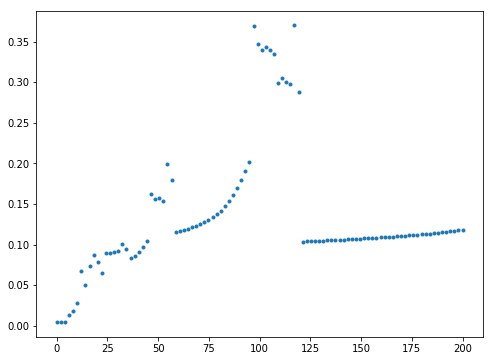

In [108]:
plt.plot(Be_fracdf['t/yr']/1e6, Be_fracdf['Be_frac'], '.')
plt.show()
#print Be_fracdf
#Be_fracdf.to_pickle('be_frac.pk')

In [ ]:

print Be_fracdf
# count number of stars above with v/vcrit above some value #
df=r_final
#print df.head()
Be_value=0.7
#print 'At time (s)', t_val ,'proportion of that are Be : '
Be_frac =df[(df['V_act']/ df['V_crit']) > Be_value].sum().frac


    

# calculate discretized distribution of rotations # 

In [ ]:
# checl integral over whole v pdf is unity 
print (integrate.cumtrapz(x=v_dist['v'], y=v_dist['pdf'], initial=0 )).max()

In [ ]:
mass_groups= r_final.groupby('M')
r_final=pd.DataFrame()
for mass,mass_group in mass_groups:
    mass_group['v_cdf_int_value']= ''
    for i in range(0 ,len(mass_group)):
        #perform integration of pdf between lower and upper bins 
        b=mass_group.iloc[i].lower_bin
        a=mass_group.iloc[i].upper_bin
        x=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'v' ]
        y=v_dist.loc[ (v_dist['v'] < a) & (v_dist['v'] >b), 'pdf' ]
        
        if len(x) != 0 and len(y) != 0:
            #print (integrate.cumtrapz(x=x, y=y, initial=0 )).max()
            mass_group.at[0,'v_cdf_int_value'] [i] = (integrate.cumtrapz(x=x, y=y, initial=0 )).max()
            
        else :
            mass_group.at[0,'v_cdf_int_value'] [i] =0
    r_final=r_final.append(mass_group)
    
    
    # check that for each mass, the sum of the integrals is unity 
    print "sum of v_cdf int vals for ", mass,"M_sun: ", np.sum(mass_group['v_cdf_int_value'])
    

In [ ]:
print r_final.head(20)

# combine mass and rotation distributions to get proportion of stars of each mass and rotation # 

In [ ]:
mass_groups= r_final.groupby('M')
r_final=pd.DataFrame()
for mass,mass_group in mass_groups:
    mass_group['frac']= ''
    for i in range(0 ,len(mass_group)):
        #fraction of stars in mass group with particular rotation
        f_r=mass_group.iloc[i].v_cdf_int_value
        #fraction of stars with mass of mass group 
        f_m=mass_dist[int(mass)]
           
        mass_group.at[0,'frac'] [i] = f_r * f_m
    r_final=r_final.append(mass_group)
    
    

print r_final.head(20)


print r_final['frac'].sum()

# export dataframe to be analysed # 

In [ ]:
r_final.to_pickle('./syn_pop.pk')

# visualize whole distribution # 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for index, row in r_final.iterrows():
    m=  [row.M]
    v=  [row.V_act]
    z=[row.frac]
    ax.bar(left=m, height=z, zs=v, zdir='y', color='r', alpha=1)


ax.set_xlabel(r'$\frac{M}{M_{\odot}}$')
ax.set_ylabel(r'$v/kms^{-1}$')
ax.set_zlabel('fraction of population')

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for mass_key in mass_list:
    for key in tot_dist.keys():
        if key[0] == mass_key: 
            m=  [mass_key]
            v=  [key[1]]
            z=tot_dist[mass_key, key[1]]
            ax.bar(left=m, height=z, zs=v, zdir='y', color='r', alpha=1)


ax.set_xlabel(r'$\frac{M}{M_{\odot}}$')
ax.set_ylabel(r'$v/kms^{-1}$')
ax.set_zlabel('fraction of population')

plt.show()

# TESTING#

['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)', '5:R/Rsun', '6:log(Mdot)[Msun/yr]', '7:logg[cgs]', '10:P[days]', '11:H', '12:He', '13:Li', '14:Be', '15:B', '16:C', '17:N', '18:O', '19:F', '20:Ne', '21:Na', '22:Mg', '23:Al', '24:Si', '25:Fe', '26:H_massfr', '27:He_massfr', '8:v_crit[km/s]', '9:v_surf[km/s]']


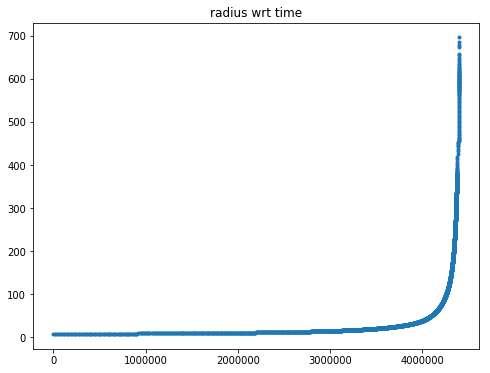

4399300.0


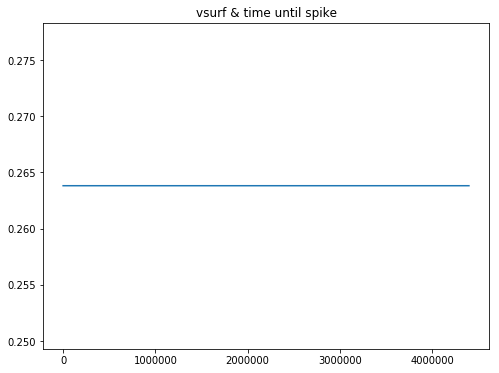

IndexError: list index out of range

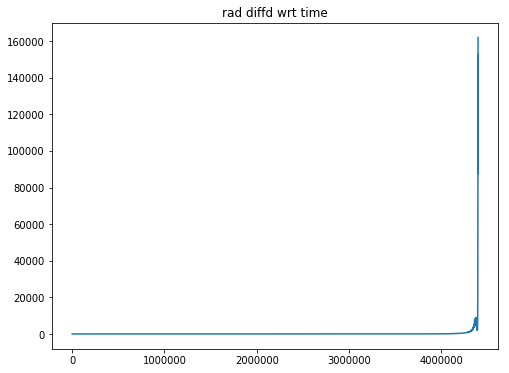

In [202]:
df, _=read_dat2file('/home/ben/Documents/Bonn-uni/internship/takeaway_data/f40-0.mw.dat2')
print df.columns.tolist()
plt.plot(df['1:t[s]'],df['5:R/Rsun'], '.')
plt.title('radius wrt time')
plt.show()

y=np.array(df['5:R/Rsun'])
t=np.array(df['1:t[s]'])


dydt= np.gradient(y, t)

print t[np.nanargmax(dydt)]

plt.plot(df['1:t[s]'][df['1:t[s]'] < t[np.nanargmax(dydt)]],df['27:He_massfr'][df['1:t[s]'] < t[np.nanargmax(dydt)]])
plt.title('vsurf & time until spike')
plt.show()
plt.plot(t, dydt /1e-6)
plt.title('rad diffd wrt time')

#get index of first value with negative gradient 
index=np.nonzero(dydt ==(filter(lambda x : x< -1e-6, dydt)[0]))[0].min()

plt.plot(t[index], dydt[index], 'ko')
plt.show()

In [201]:
print filter(lambda x : x< 0, dydt)[0]
#print np.nonzero(dydt ==(filter(lambda x : x > 120e8, dydt)))
index=np.nonzero(dydt ==(filter(lambda x : x< -1e-6, dydt)[0]))[0].min()
print index

print len(dydt)
print dydt[index]

#print dydt[np.nanargmin(dydt)]

IndexError: list index out of range

['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)', '5:R/Rsun', '6:log(Mdot)[Msun/yr]', '7:logg[cgs]', '8:v_crit[km/s]', '9:v_surf[km/s]', '10:P[days]', '11:H', '12:He', '13:Li', '14:Be', '15:B', '16:C', '17:N', '18:O', '19:F', '20:Ne', '21:Na', '22:Mg', '23:Al', '24:Si', '25:Fe', '26:H_massfr', '27:He_massfr']


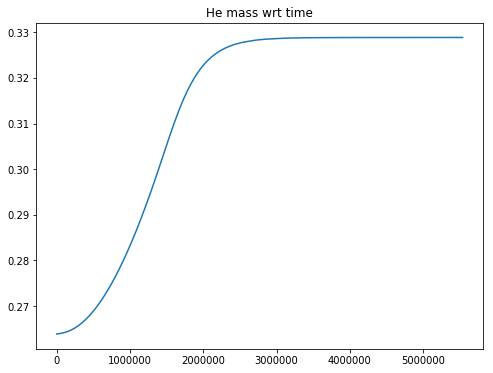

5538640.0


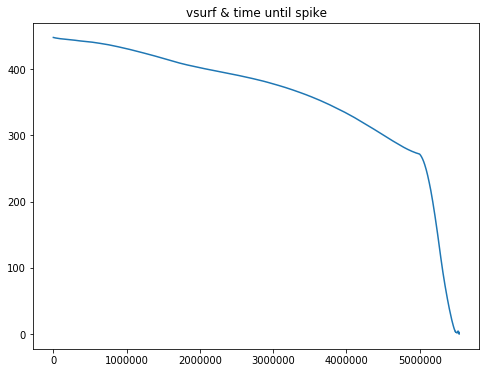

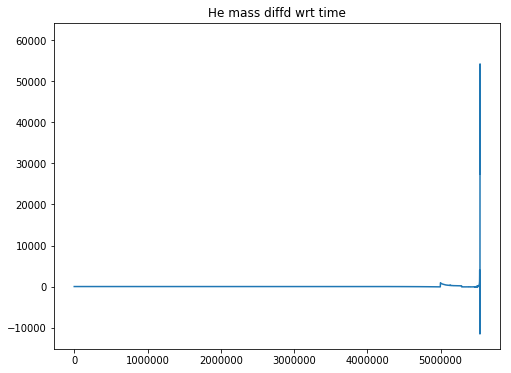

In [148]:


df, _=read_dat2file('/home/ben/Documents/Bonn-uni/internship/takeaway_data/f35-430.mw.dat2')
print df.columns.tolist()
plt.plot(df['1:t[s]'],df['27:He_massfr'], '-')
plt.title('He mass wrt time')
plt.show()

y=np.array(df['6:log(Mdot)[Msun/yr]'])
t=np.array(df['1:t[s]'])


dydt= np.gradient(y, t)

print t[np.nanargmax(dydt)]

if np.nanmax(dydt)> 1e-7 :

    plt.plot(df['1:t[s]'][df['1:t[s]'] < t[np.nanargmax(dydt)]],df['9:v_surf[km/s]'][df['1:t[s]'] < t[np.nanargmax(dydt)]])
    plt.title('vsurf & time until spike')
    plt.show()
plt.plot(t, dydt/1e-8)
plt.title('He mass diffd wrt time')
plt.show()

f3-0.mw.dat2 8.233333333333768


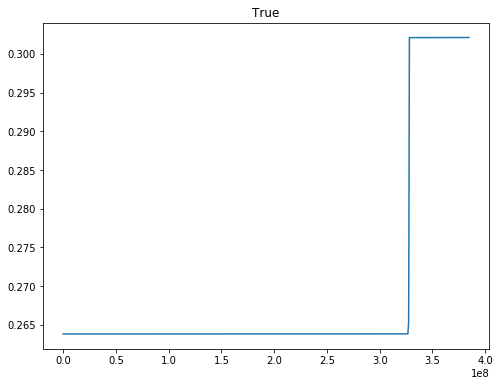

f3-50.mw.dat2 8.058888888889506


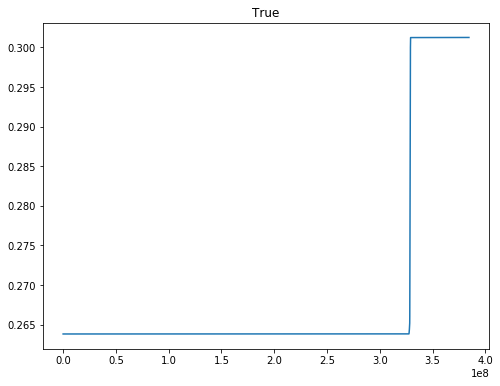

f3-100.mw.dat2 7.670555555555999


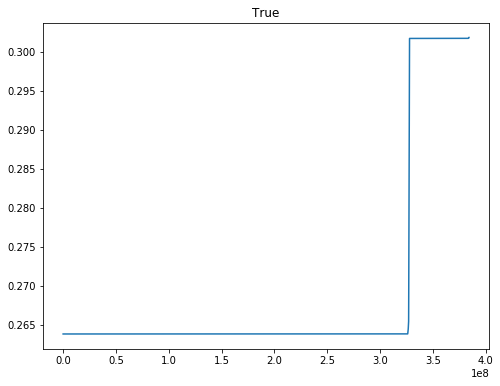

f3-150.mw.dat2 8.285555555554975


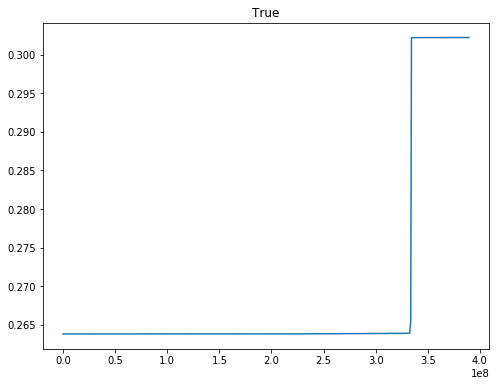

f3-200.mw.dat2 7.724444444443537


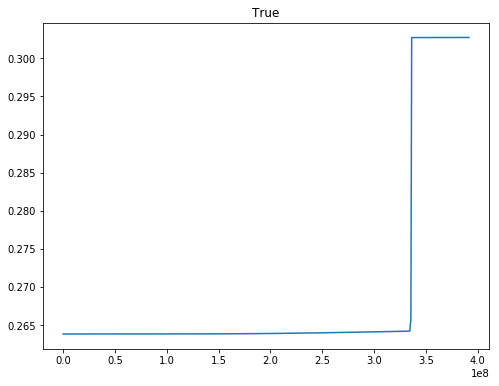

f3-250.mw.dat2 8.433333333336916


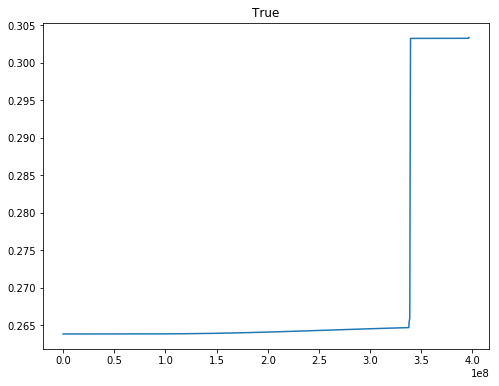

f3-300.mw.dat2 7.812777777778081


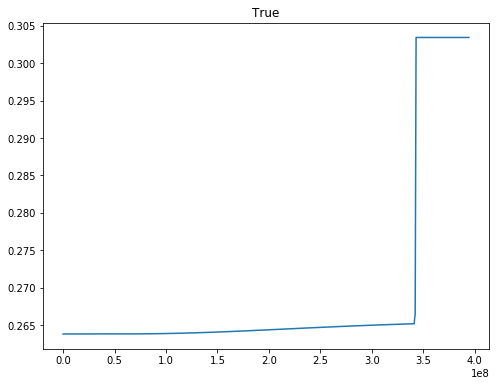

f3-350.mw.dat2 8.26666666666311


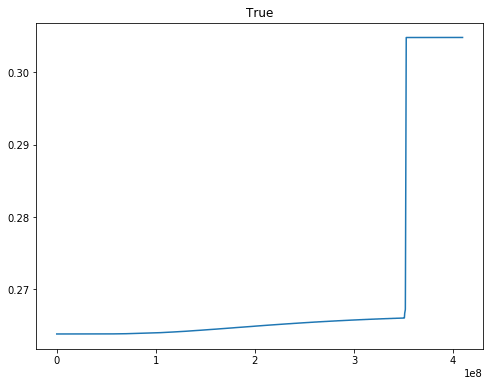

f3-400.mw.dat2 8.1666666666656


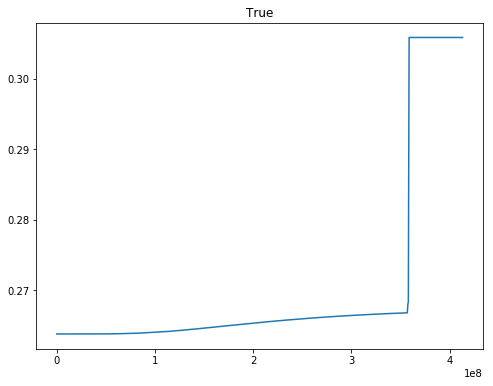

f3-420.mw.dat2 8.333333333333309


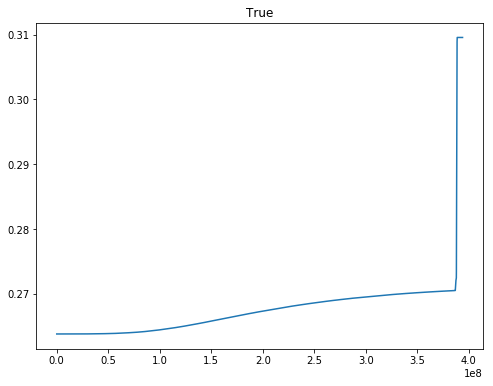

f3-450.mw.dat2 7.900000000001059


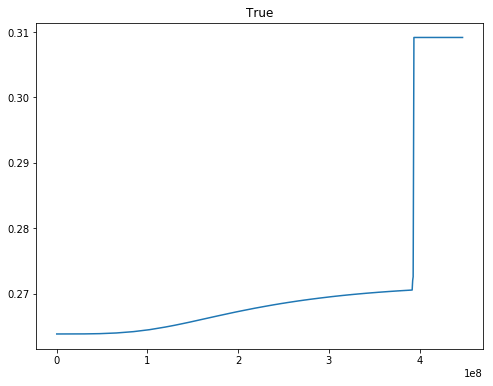

f3-500.mw.dat2 7.316666666667802


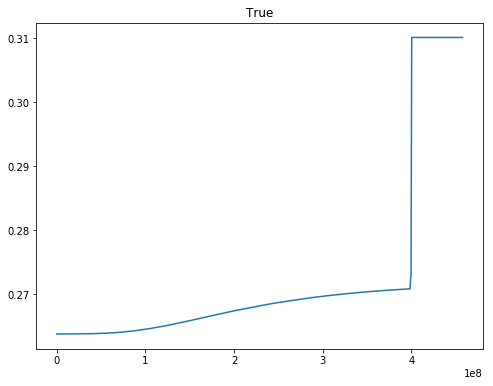

f5-0.mw.dat2 inf


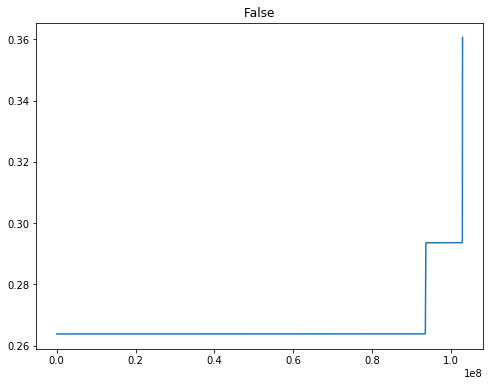

f5-50.mw.dat2 inf


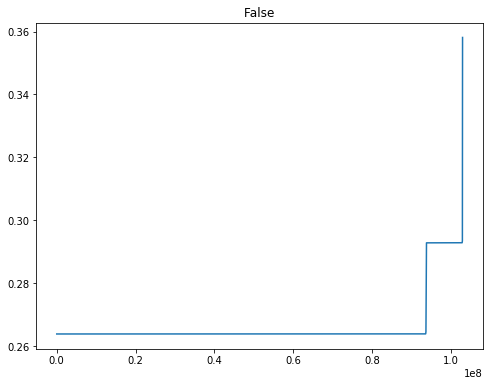

f5-100.mw.dat2 40.49999999998716


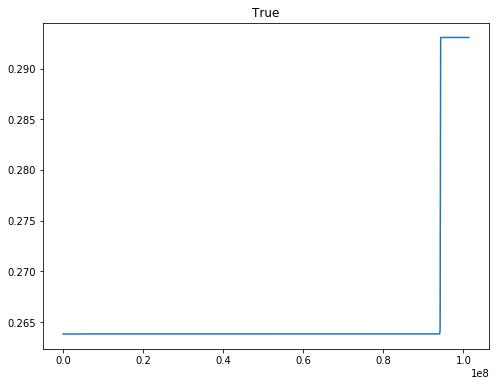

f5-150.mw.dat2 inf


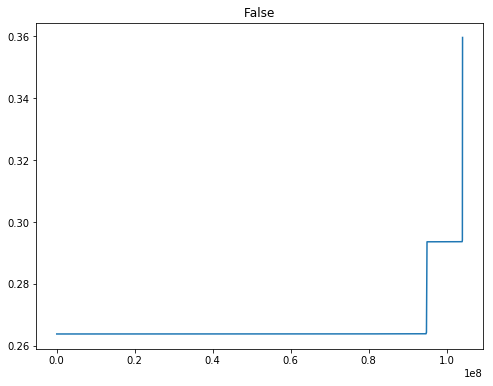

f5-200.mw.dat2 42.124999999993776


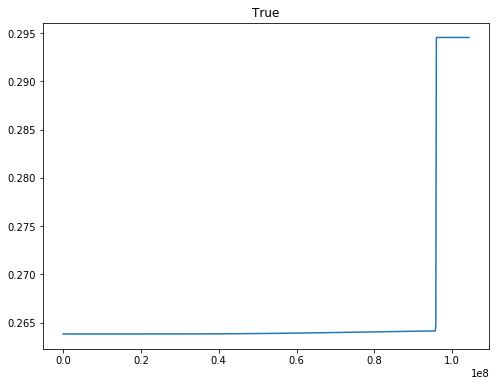

f5-250.mw.dat2 inf


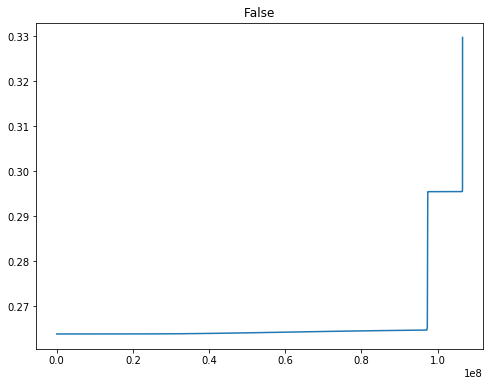

f5-300.mw.dat2 inf


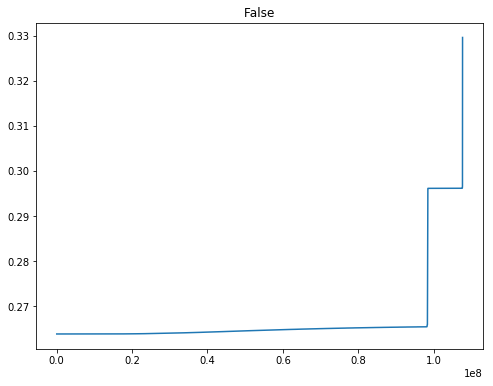

f5-350.mw.dat2 24.600000000002442


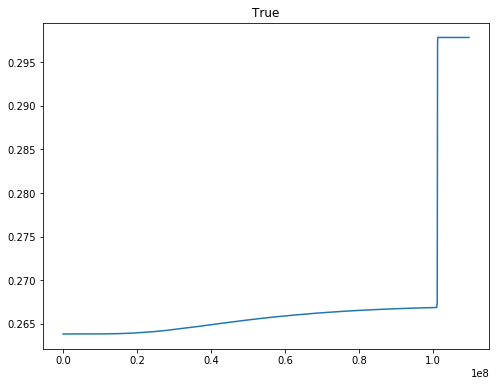

f5-400.mw.dat2 26.099999999998953


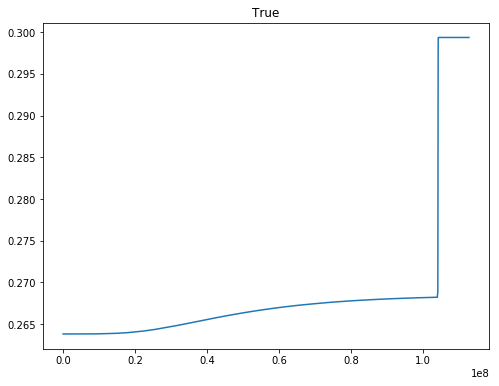

f5-450.mw.dat2 27.05000000000036


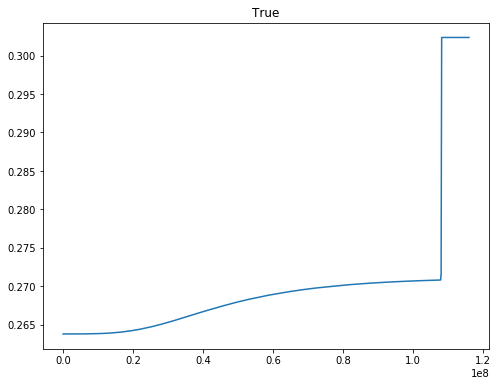

f5-500.mw.dat2 27.50000000000202


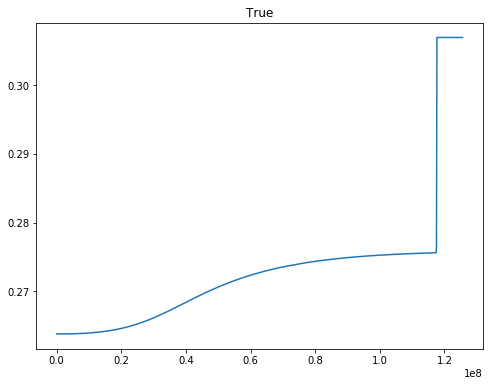

f5-550.mw.dat2 26.300000000002104


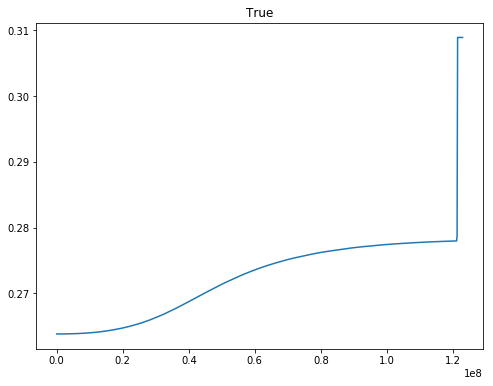

f7-0.mw.dat2 275.9999999999926


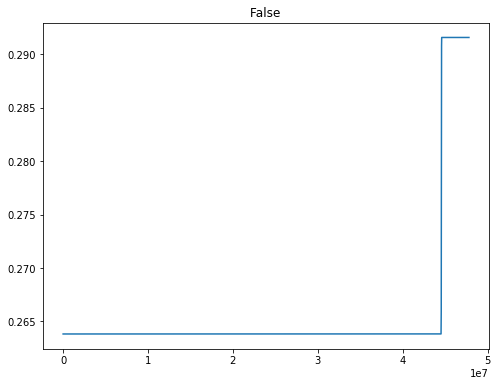

f7-50.mw.dat2 217.0000000000123


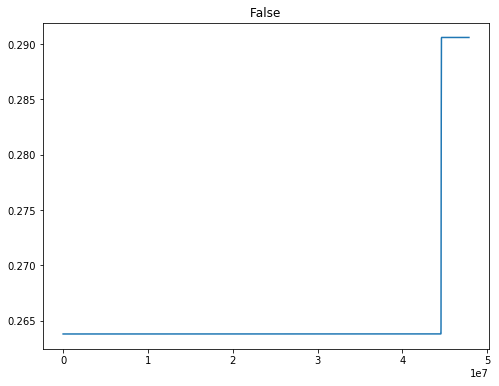

f7-100.mw.dat2 394.9999999999787


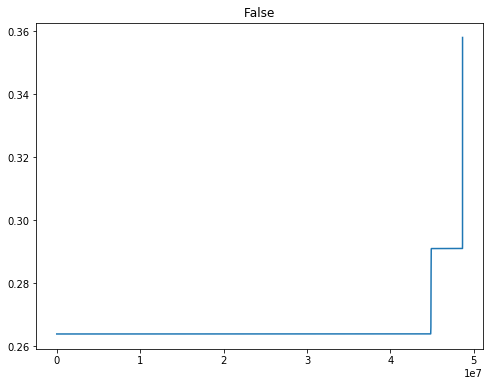

f7-150.mw.dat2 128.83333333330546


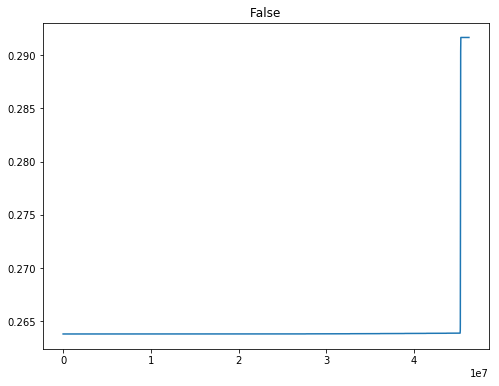

f7-200.mw.dat2 127.50000000000175


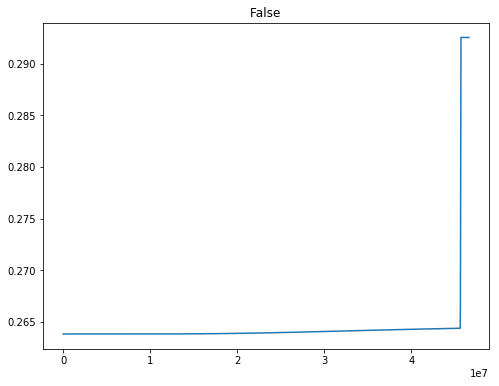

f7-250.mw.dat2 124.49999999999787


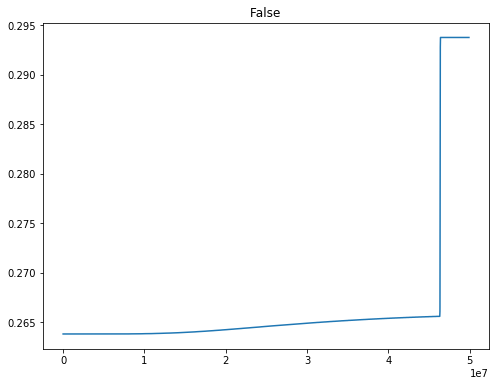

f7-300.mw.dat2 119.83333333333724


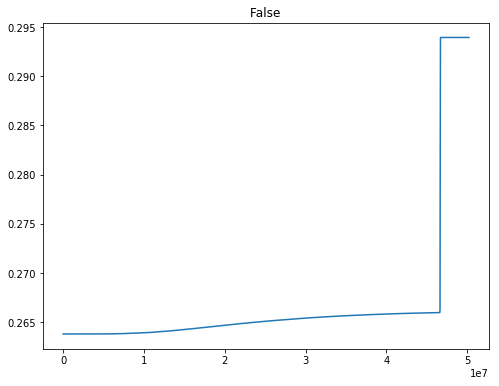

f7-350.mw.dat2 124.1666666666882


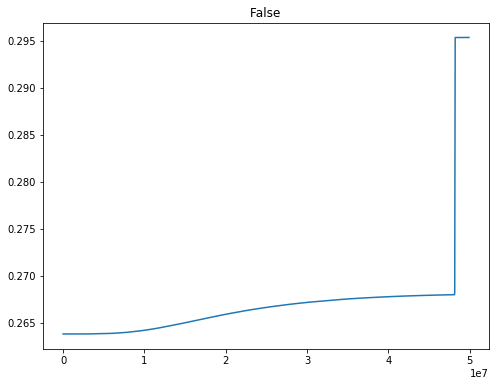

f7-400.mw.dat2 135.9999999999838


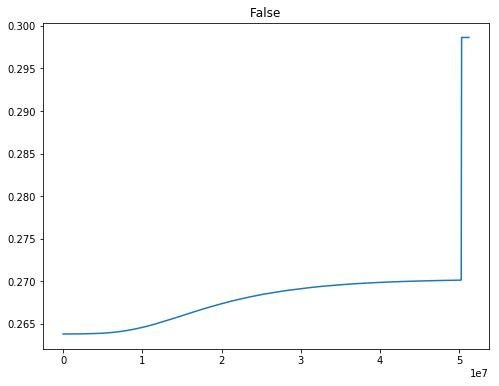

f7-440.mw.dat2 146.33333333335332


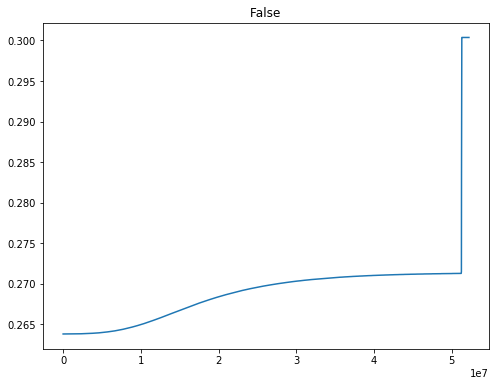

f7-450.mw.dat2 151.00000000005733


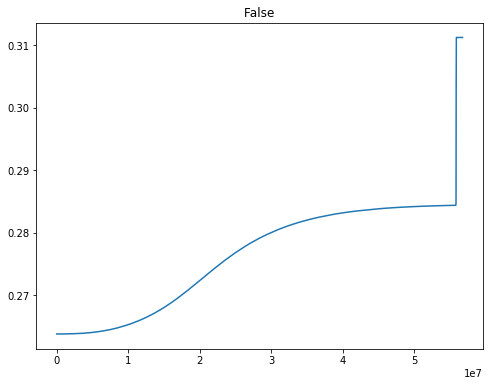

f7-500.mw.dat2 168.33333333337447


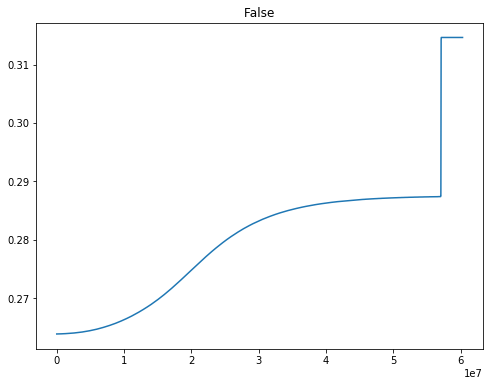

f9-0.mw.dat2 375.0000000000064


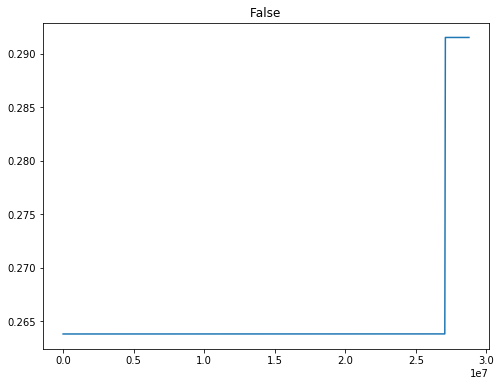

f9-50.mw.dat2 339.99999999999744


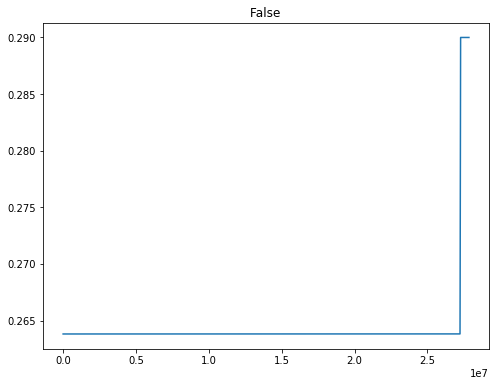

f9-100.mw.dat2 257.16666666667356


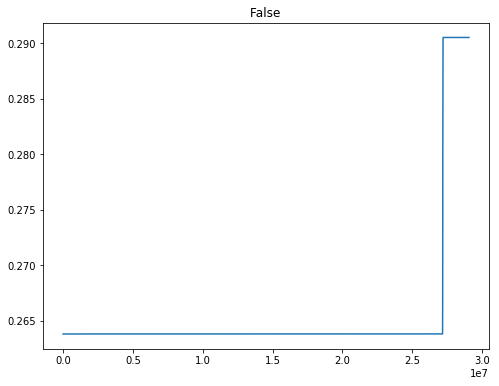

f9-150.mw.dat2 192.000000000009


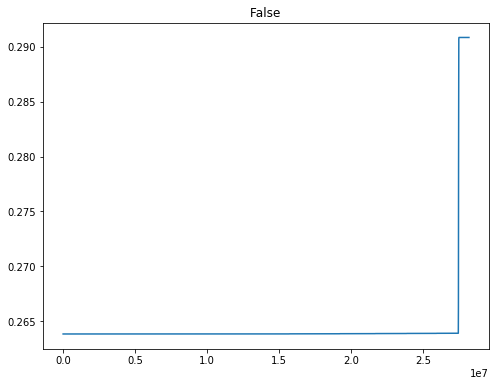

f9-200.mw.dat2 169.49999999999085


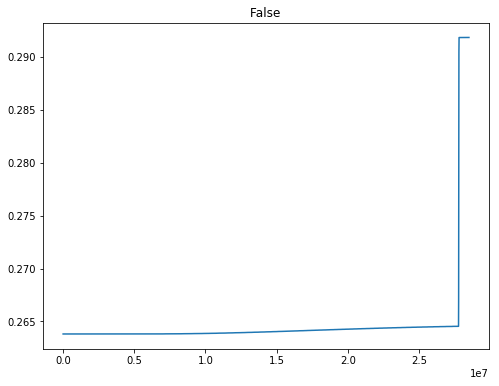

f9-250.mw.dat2 164.00000000000182


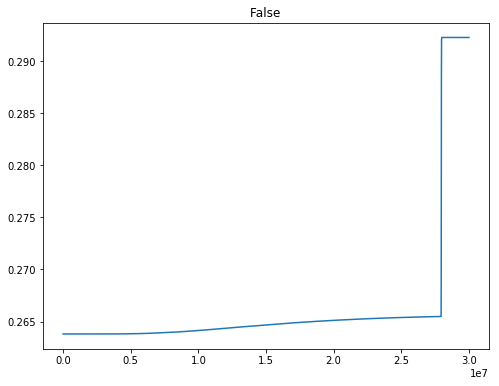

f9-300.mw.dat2 148.99999999998246


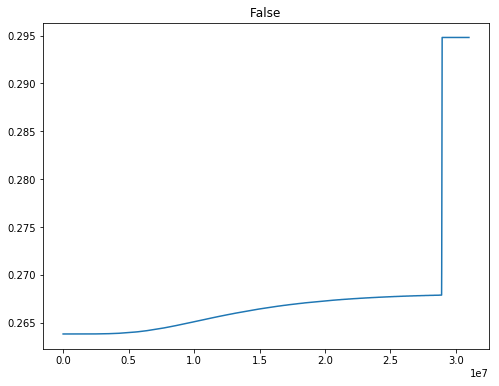

f9-350.mw.dat2 153.0000000000021


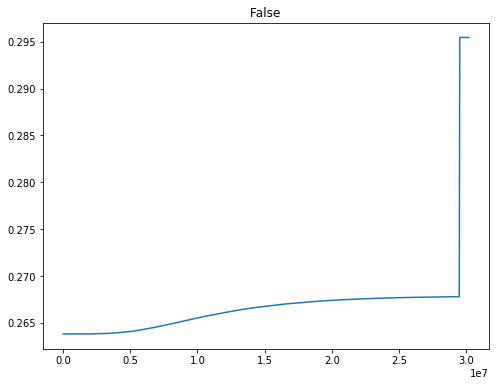

f9-400.mw.dat2 165.4999999999929


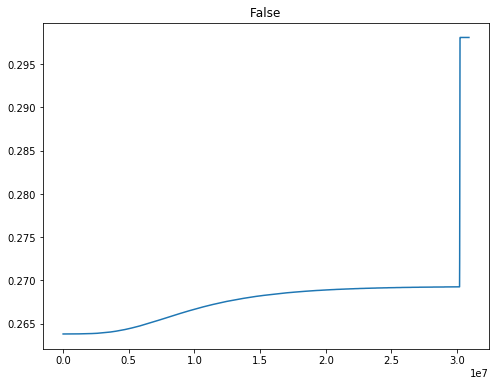

f9-450.mw.dat2 192.49999999998434


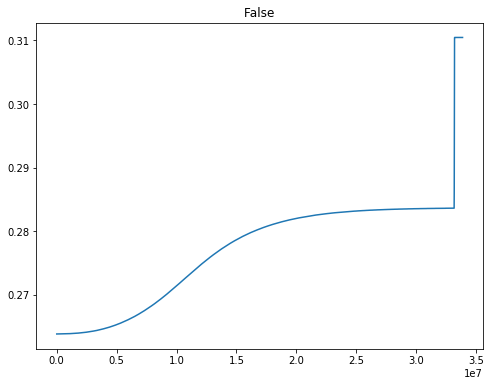

f9-500.mw.dat2 181.99999999998164


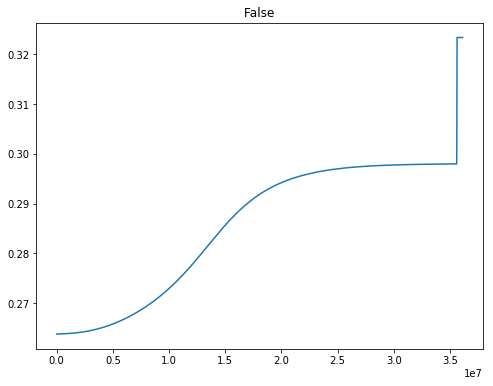

f10-0.mw.dat2 inf


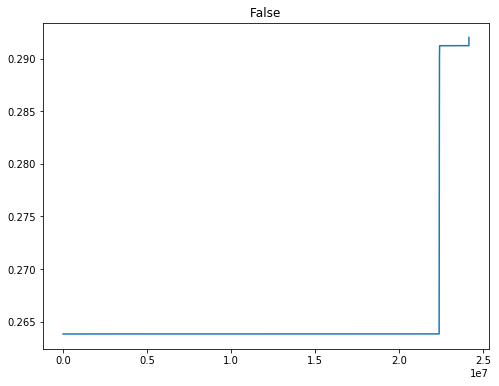

f10-50.mw.dat2 308.9999999999647


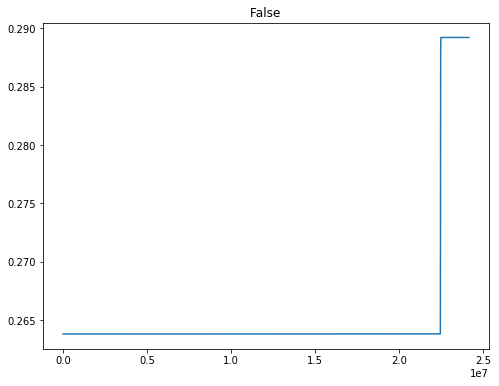

f10-100.mw.dat2 282.999999999989


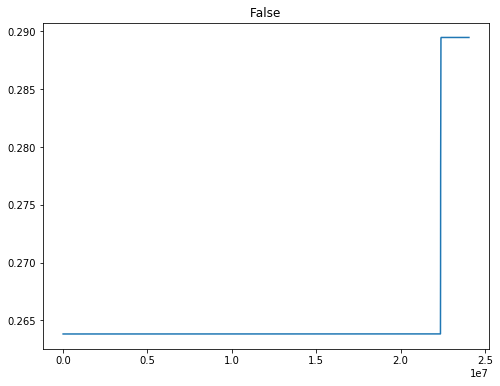

f10-150.mw.dat2 196.00000000000693


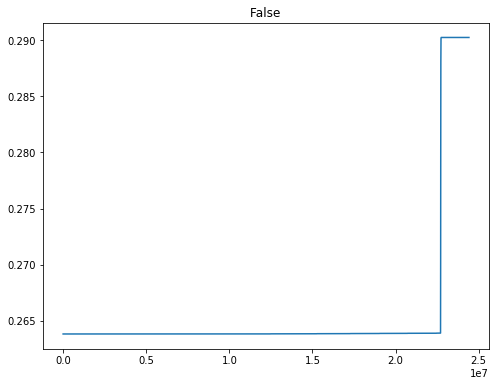

f10-200.mw.dat2 167.00000000000568


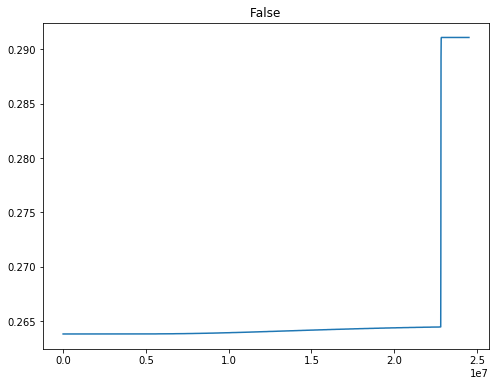

f10-250.mw.dat2 170.50000000002825


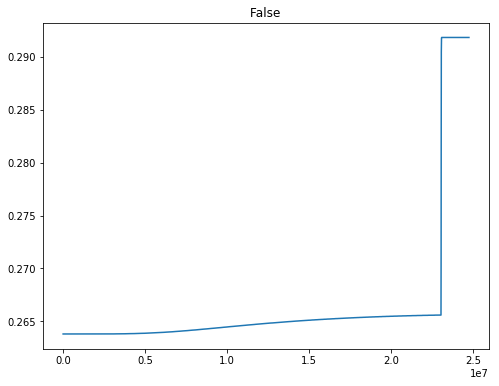

f10-300.mw.dat2 154.49999999999318


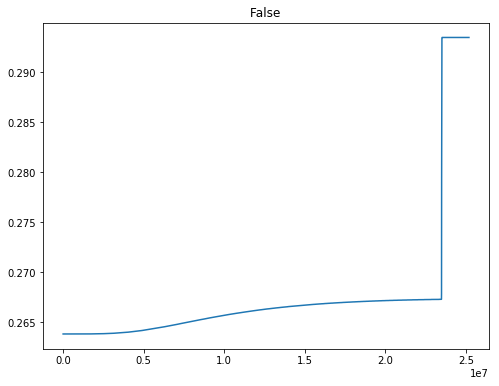

f10-350.mw.dat2 154.49999999999318


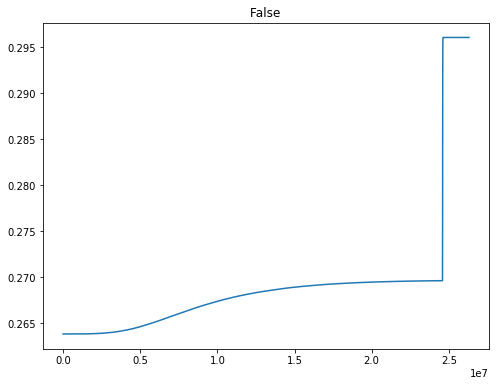

f10-400.mw.dat2 164.99999999999588


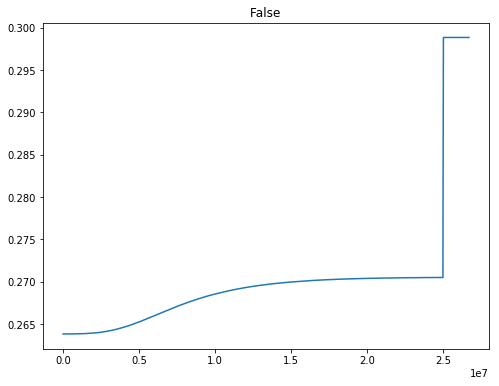

f10-450.mw.dat2 152.50000000002674


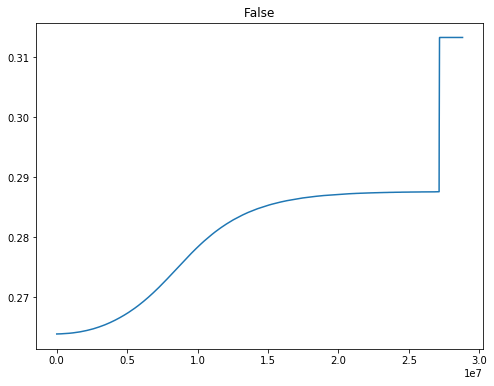

f10-500.mw.dat2 142.99999999999642


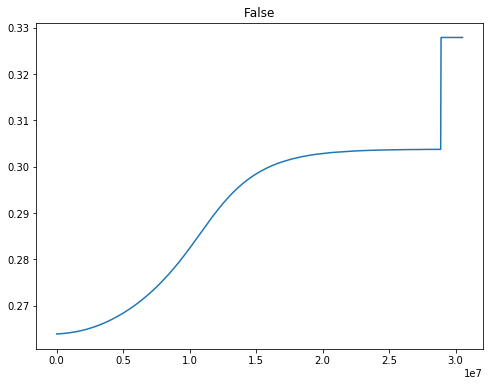

f12-0.mw.dat2 272.4999999999863


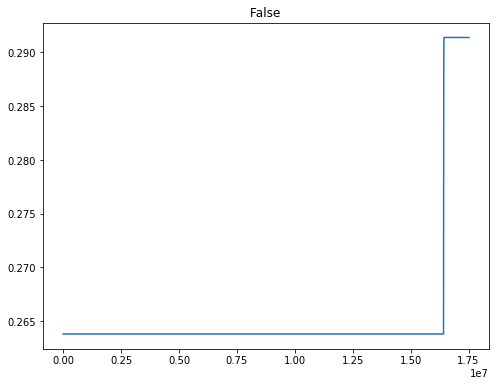

f12-50.mw.dat2 207.16666666667774


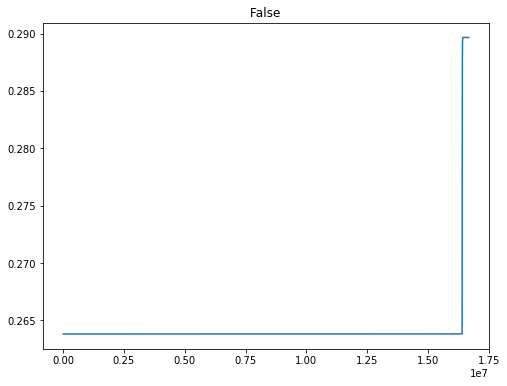

f12-100.mw.dat2 267.00000000001893


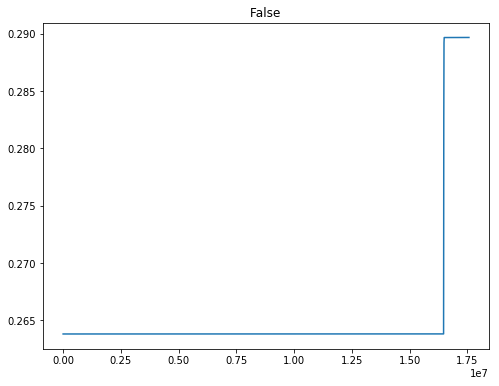

f12-150.mw.dat2 147.4999999999914


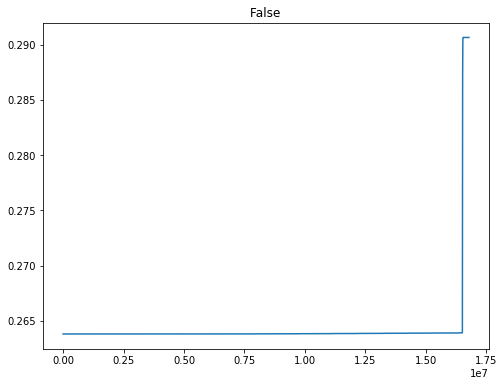

f12-200.mw.dat2 194.50000000001583


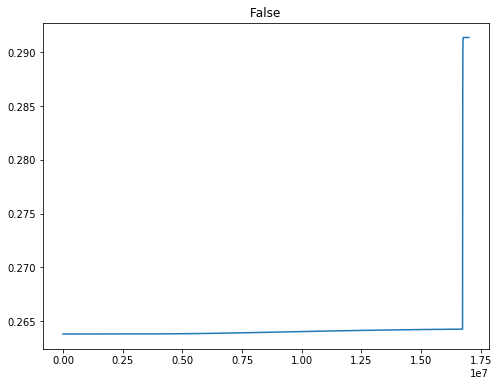

f12-250.mw.dat2 138.9999999999985


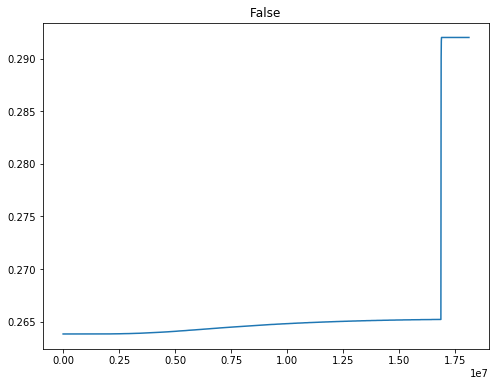

f12-300.mw.dat2 140.50000000003297


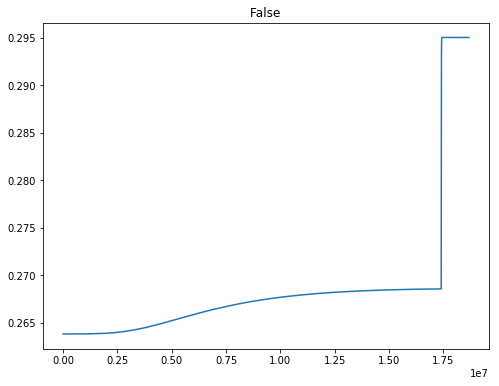

f12-350.mw.dat2 166.0000000000333


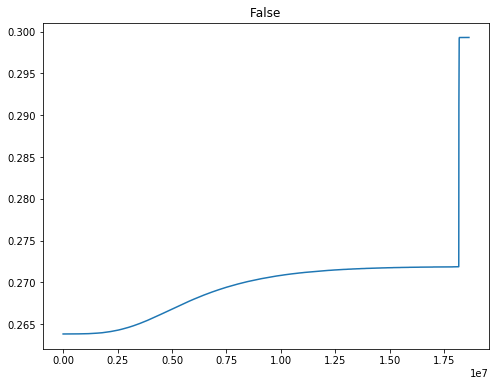

f12-400.mw.dat2 189.9999999999992


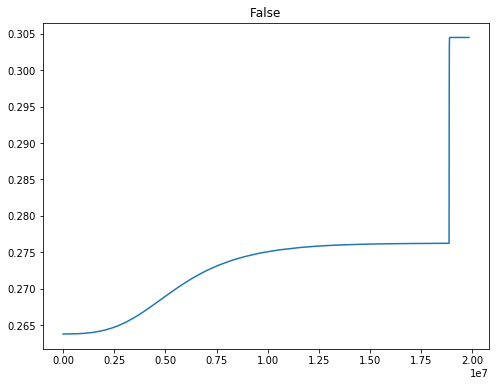

f12-450.mw.dat2 128.4999999999958


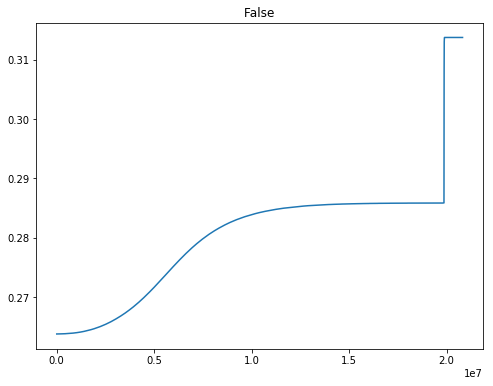

f12-500.mw.dat2 120.00000000000291


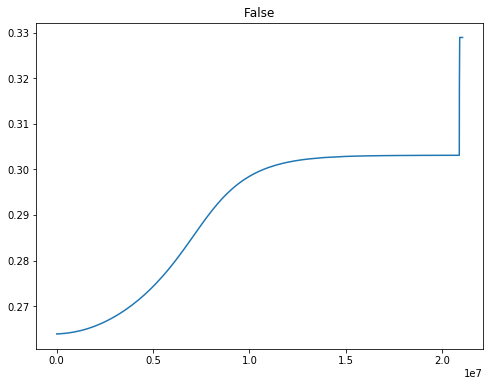

f15-0.mw.dat2 180.99999999999844


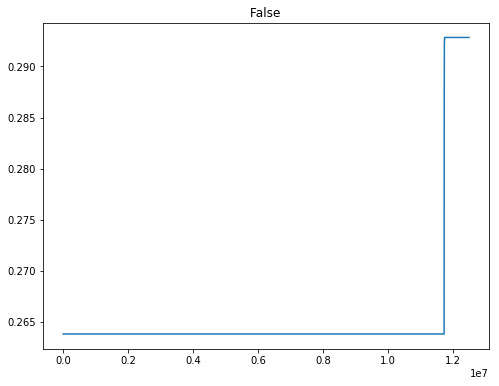

f15-50.mw.dat2 446.49999999999375


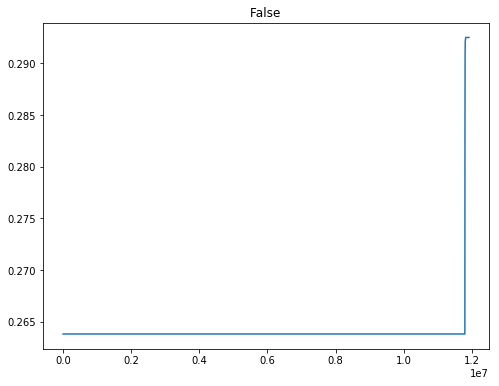

f15-100.mw.dat2 316.9999999999822


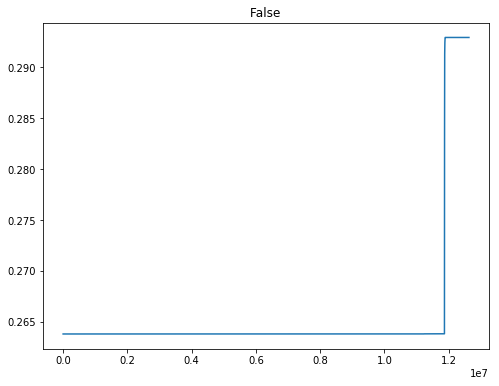

f15-150.mw.dat2 137.49999999998573


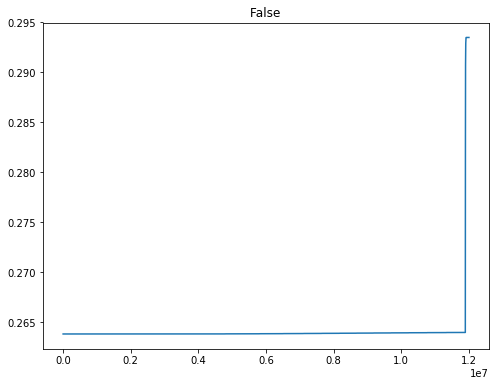

f15-200.mw.dat2 154.1666666666835


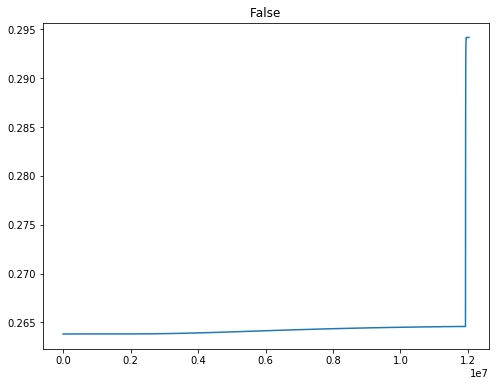

f15-250.mw.dat2 128.33333333331387


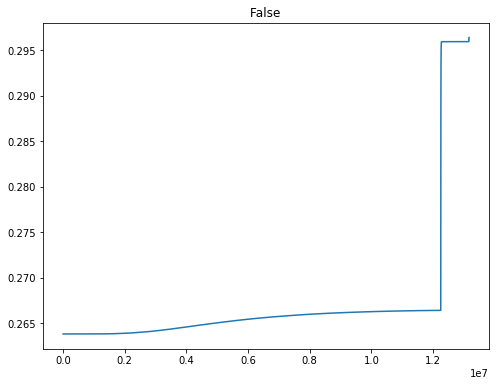

f15-300.mw.dat2 121.99999999999103


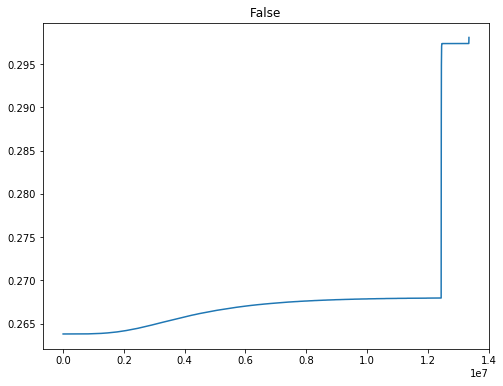

f15-350.mw.dat2 192.000000000009


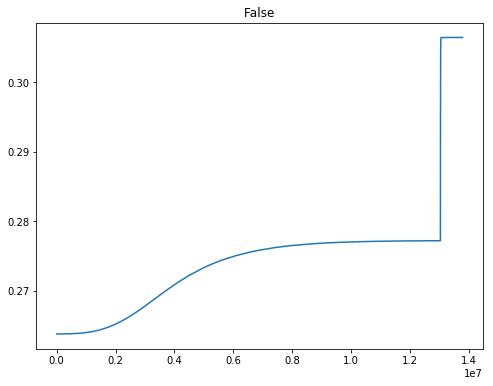

f15-400.mw.dat2 224.49999999998946


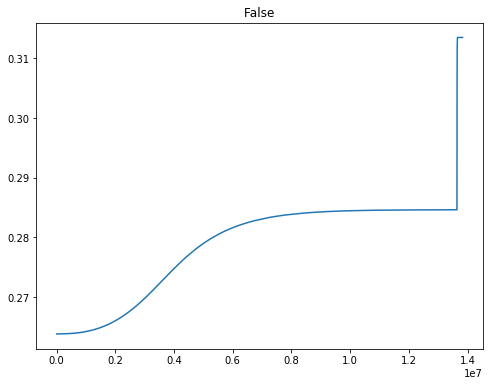

f15-450.mw.dat2 124.50000000001955


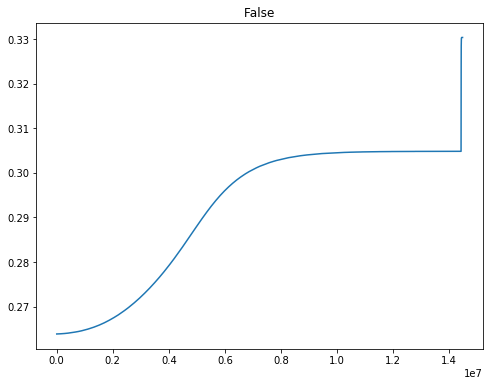

f15-500.mw.dat2 122.00000000001272


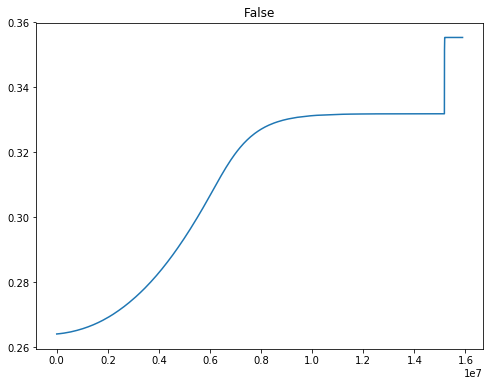

f15-550.mw.dat2 1.9068745493225563


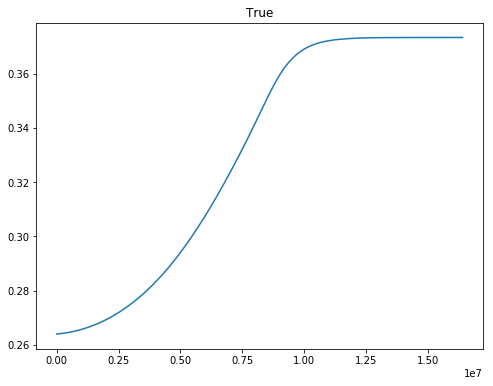

f20-0.mw.dat2 7520.000000000443


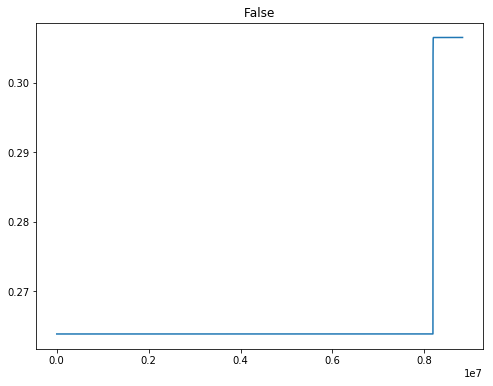

f20-50.mw.dat2 1073.9379084967036


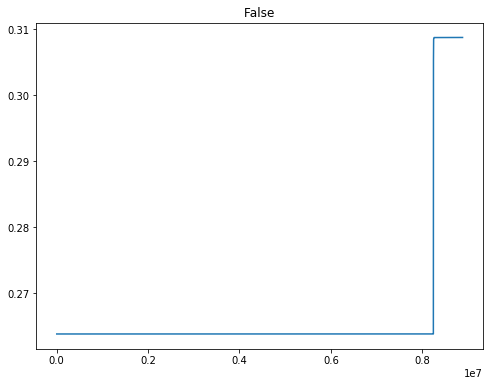

f20-100.mw.dat2 5815.00000000016


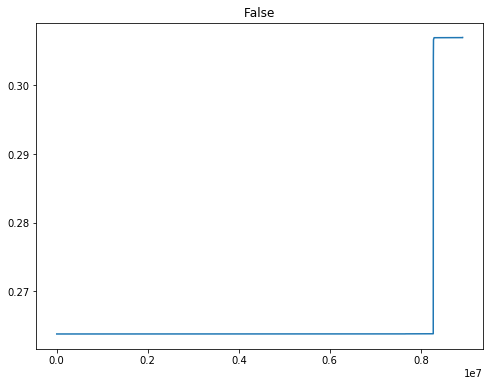

f20-150.mw.dat2 1296.4086687306713


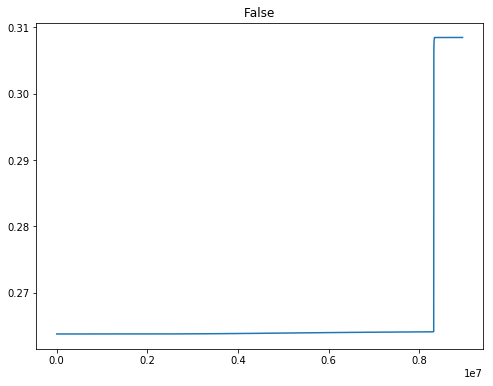

f20-200.mw.dat2 752.145299145275


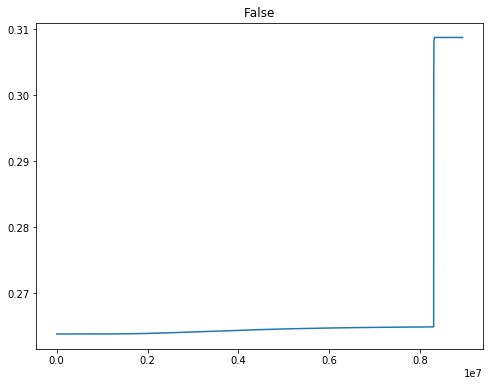

f20-250.mw.dat2 773.3333333333377


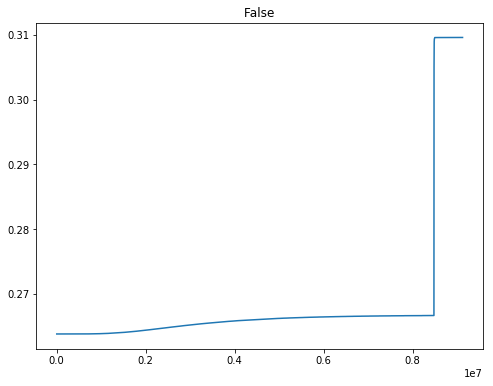

f20-300.mw.dat2 6664.999999999969


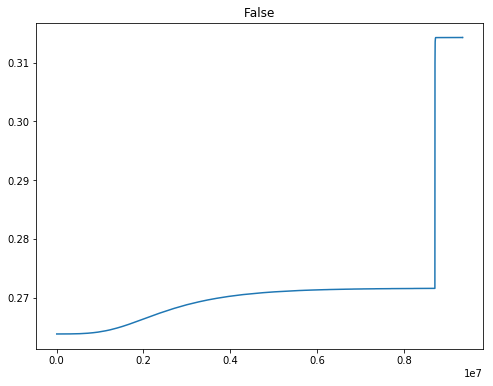

f20-350.mw.dat2 6444.999999999888


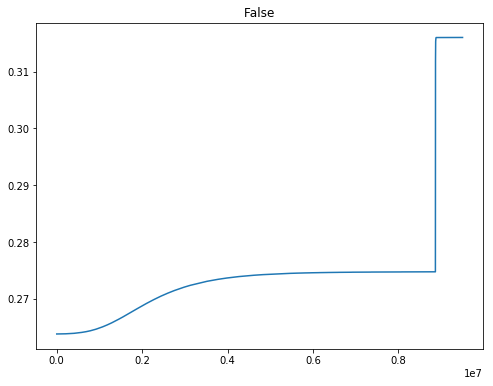

f20-400.mw.dat2 725.0000000000312


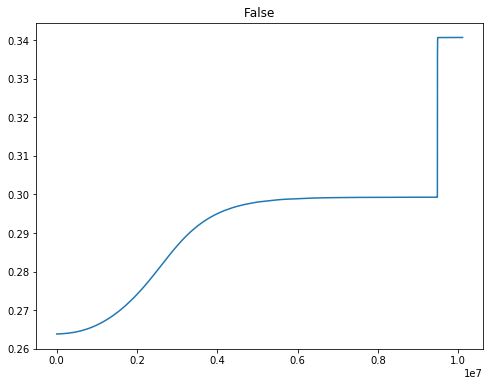

f20-450.mw.dat2 1039.9999999997217


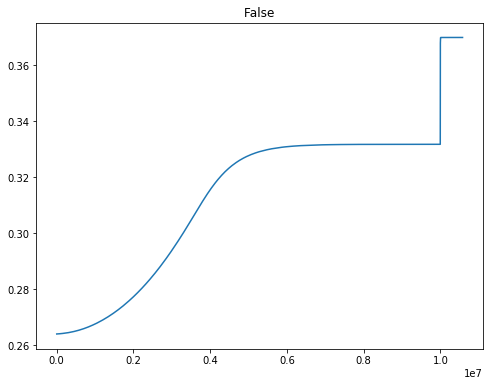

f20-480.mw.dat2 4.49999999999496


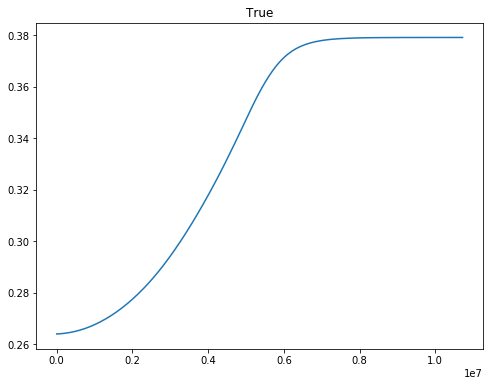

f20-500.mw.dat2 236.99999999998028


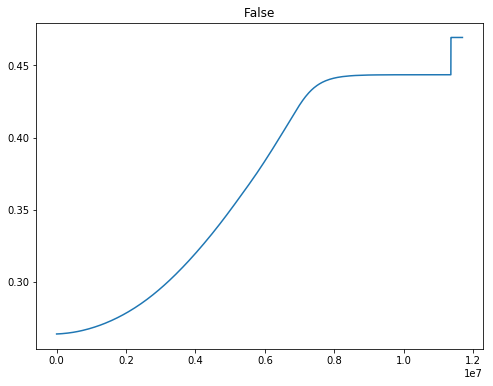

f20-520.mw.dat2 4.046942928663408


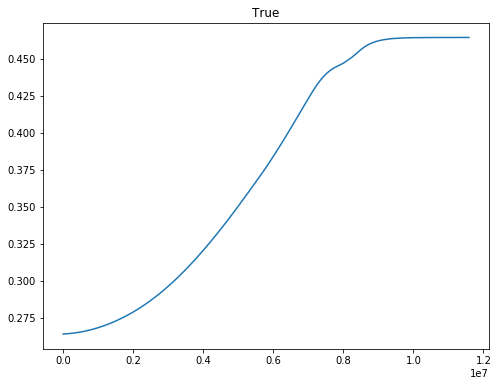

f20-550.mw.dat2 5.545063552345653


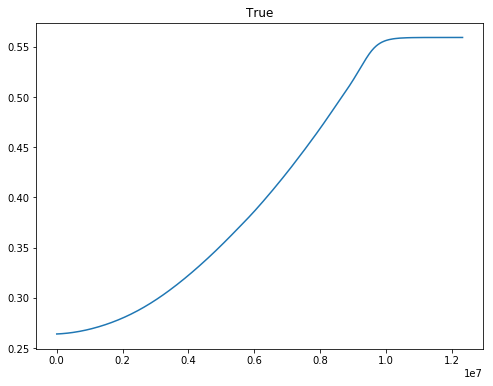

f25-0.mw.dat2 1306.6666666665394


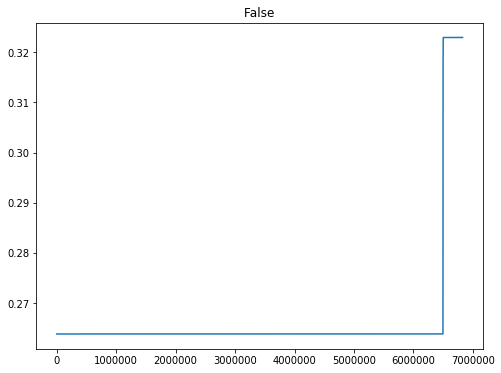

f25-50.mw.dat2 1226.6666666665808


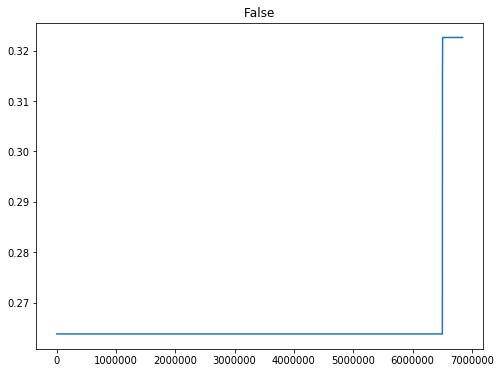

f25-100.mw.dat2 1124.9999999997374


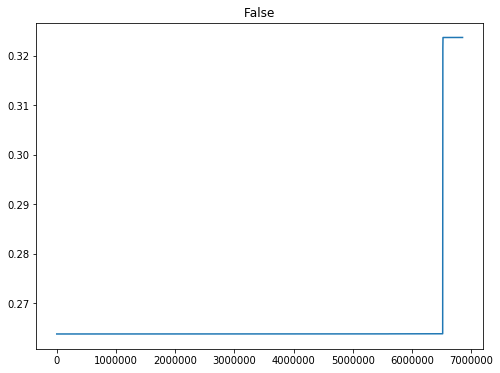

f25-150.mw.dat2 1158.3333333336534


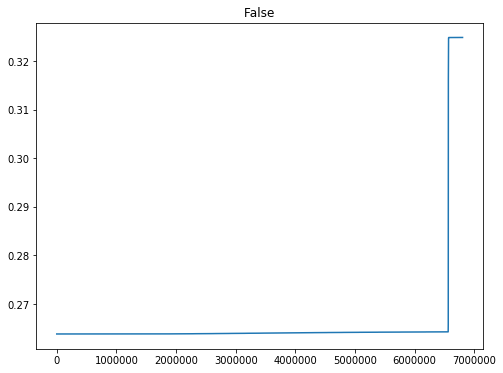

f25-200.mw.dat2 1024.9999999999843


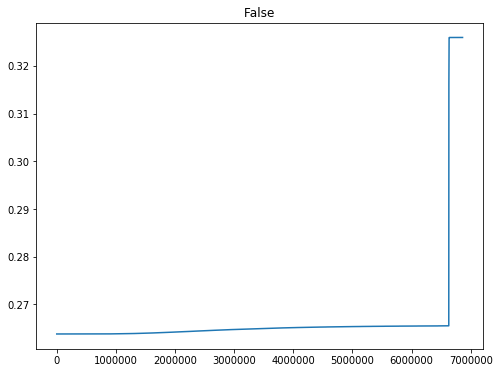

f25-250.mw.dat2 2745.8333333334194


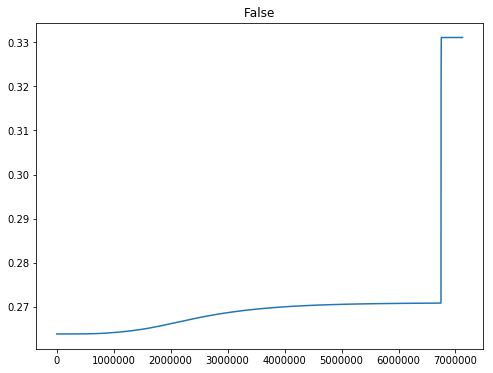

f25-300.mw.dat2 6524.999999999586


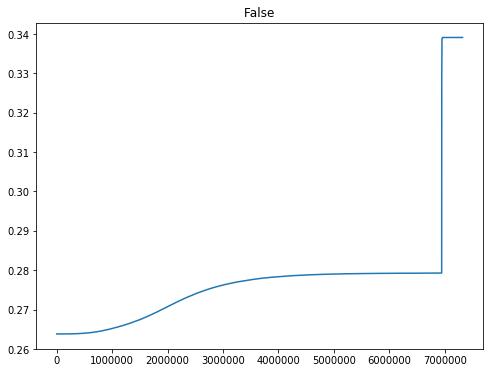

f25-350.mw.dat2 10233.333333333796


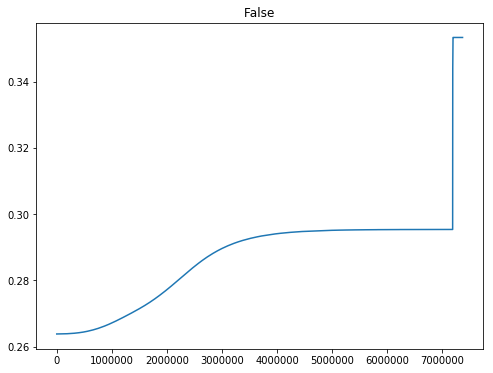

f25-400.mw.dat2 4186.999999999941


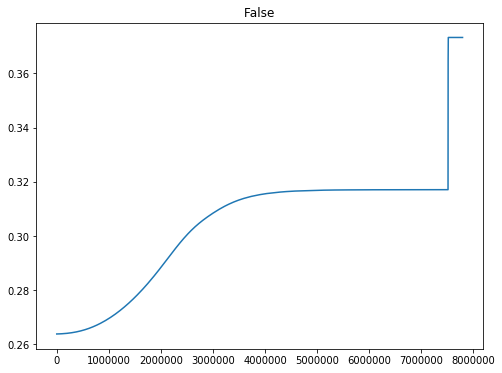

f25-420.mw.dat2 3.387055364389329


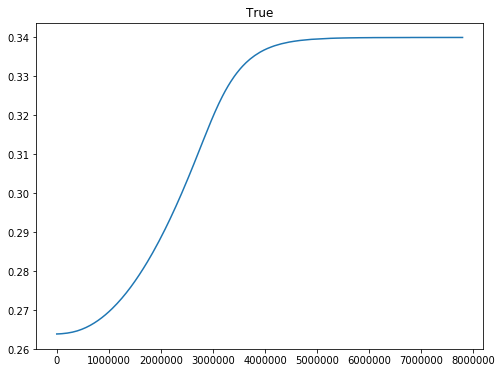

f25-440.mw.dat2 3.8578404401528292


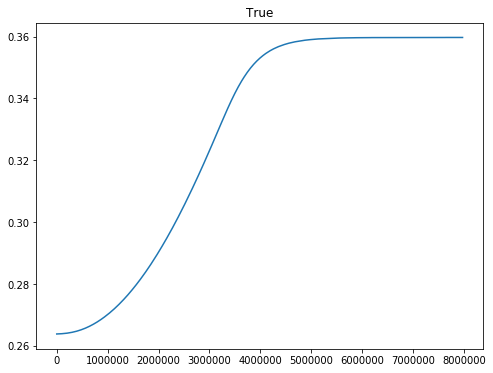

f25-450.mw.dat2 1400.0000000000123


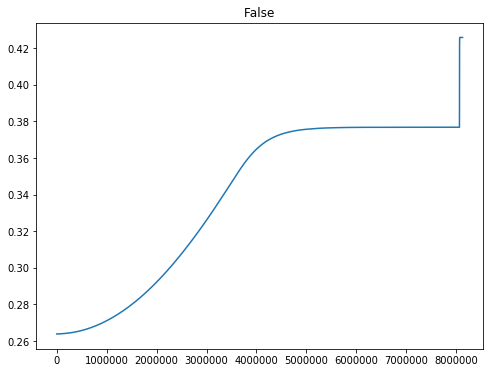

f25-480.mw.dat2 4.615349057617651


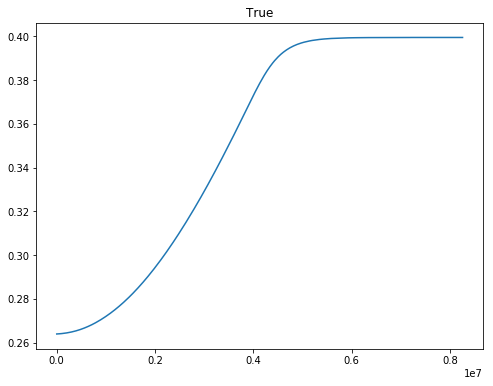

f25-500.mw.dat2 1255.0000000000061


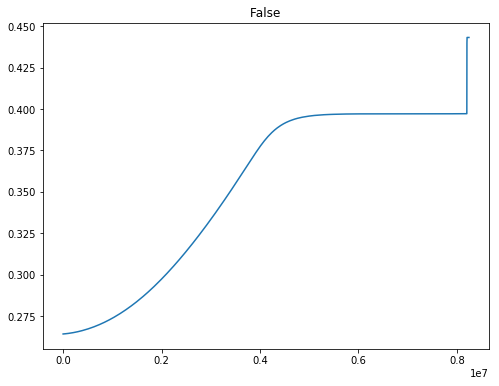

f25-510.mw.dat2 5.834784935130116


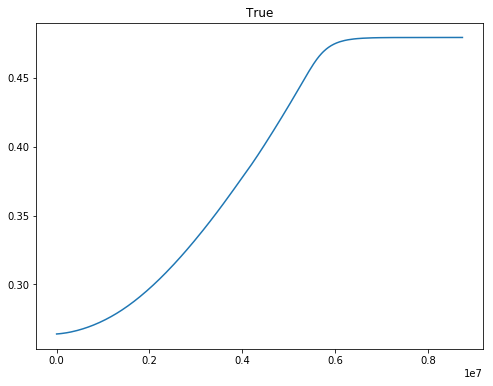

f25-520.mw.dat2 4.709974074202738


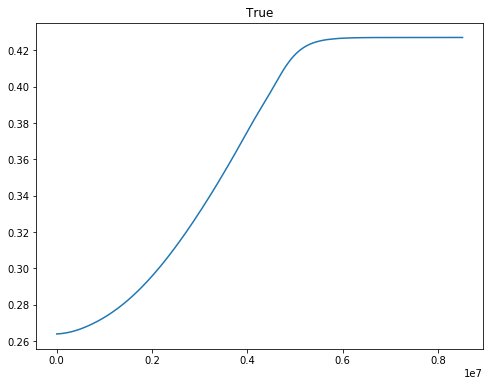

f25-550.mw.dat2 5.864037599977775


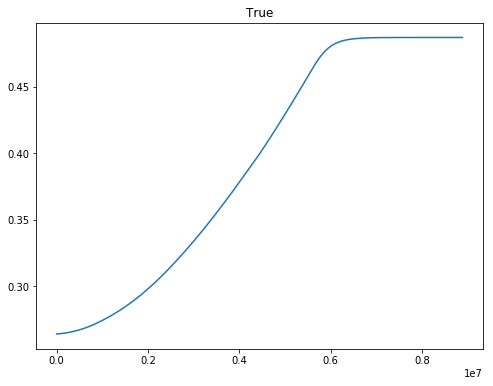

f30-0.mw.dat2 6689.999999999821


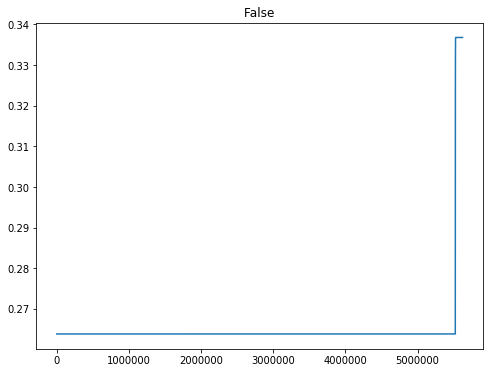

f30-50.mw.dat2 2639.999999999934


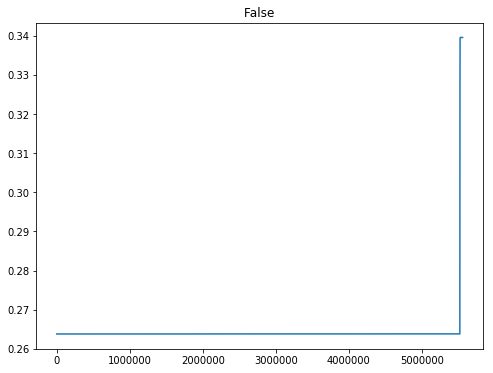

f30-100.mw.dat2 3380.0000000003965


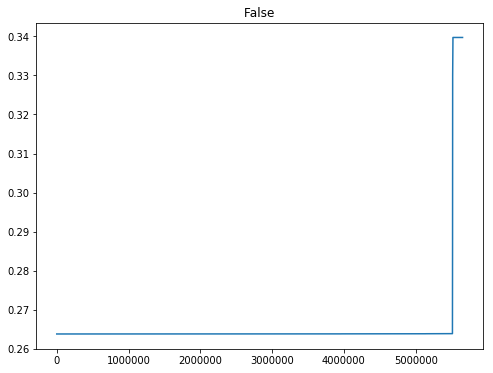

f30-150.mw.dat2 1188.3333333336486


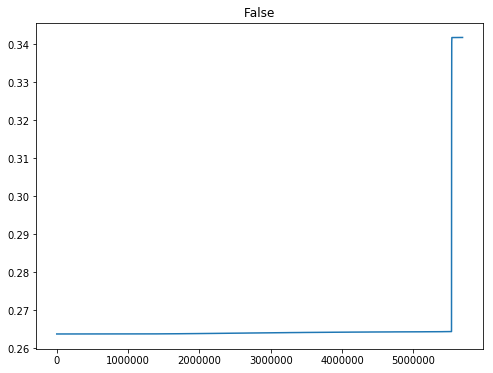

f30-200.mw.dat2 1010.0000000002468


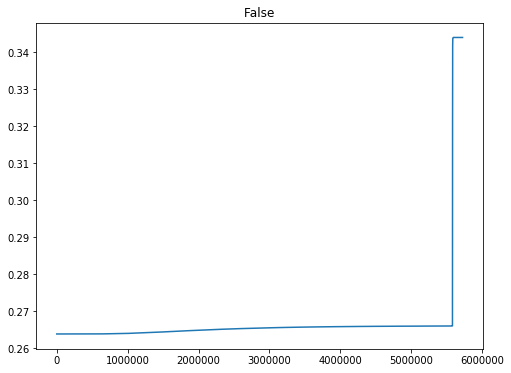

f30-250.mw.dat2 4424.999999999915


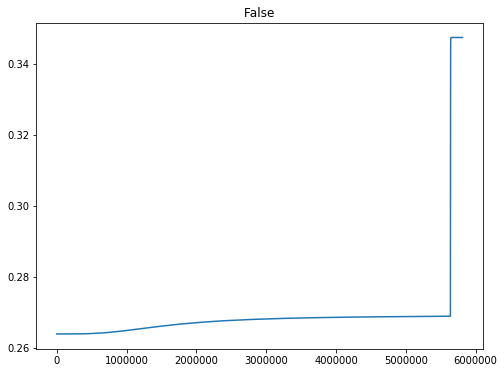

f30-300.mw.dat2 2755.0000000001182


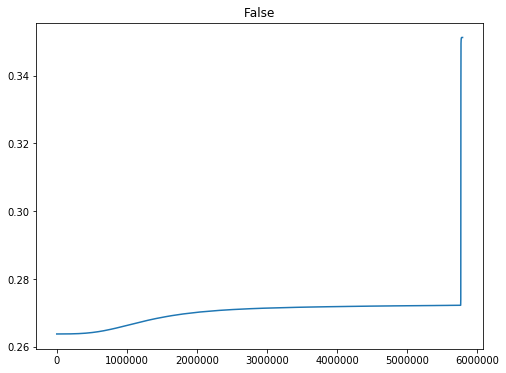

f30-350.mw.dat2 929.9999999996811


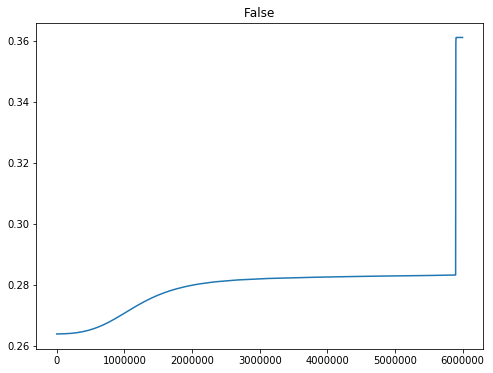

f30-400.mw.dat2 949.9999999999093


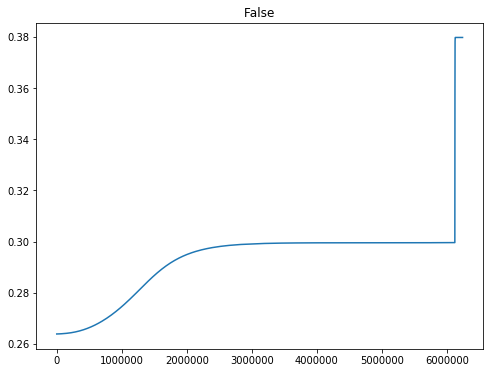

f30-450.mw.dat2 3841.6666666666633


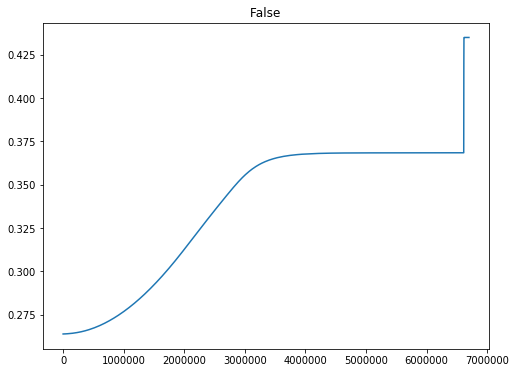

f30-460.mw.dat2 5.808761026899487


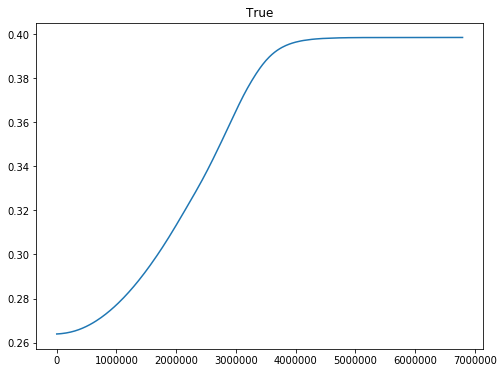

f30-470.mw.dat2 6.686397446592331


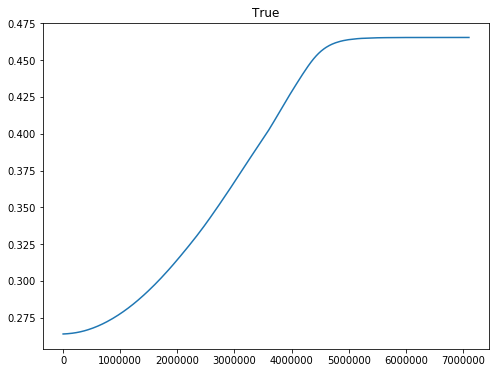

f30-500.mw.dat2 740.0000000001155


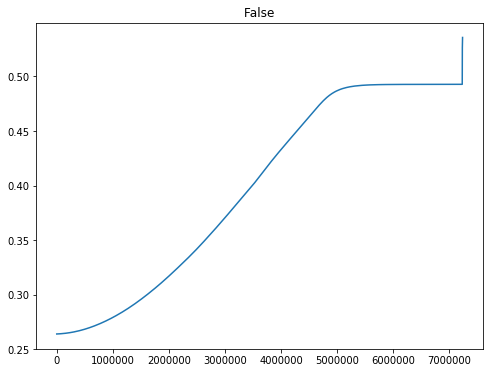

f30-520.mw.dat2 6.734928663402071


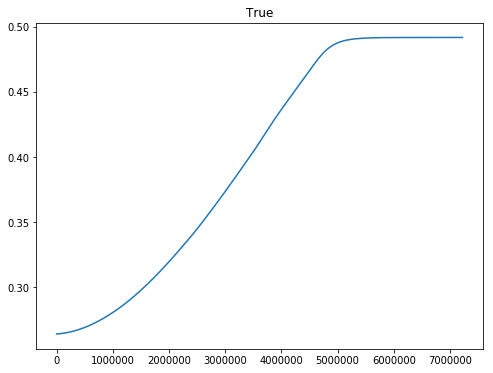

f30-550.mw.dat2 7.096659060079028


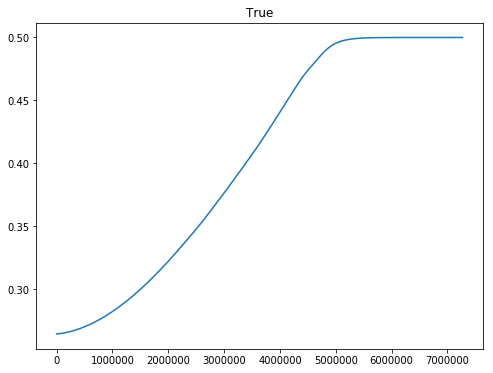

f35-0.mw.dat2 534.9999999997717


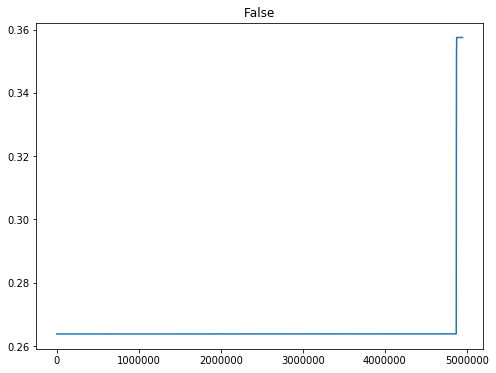

f35-50.mw.dat2 inf


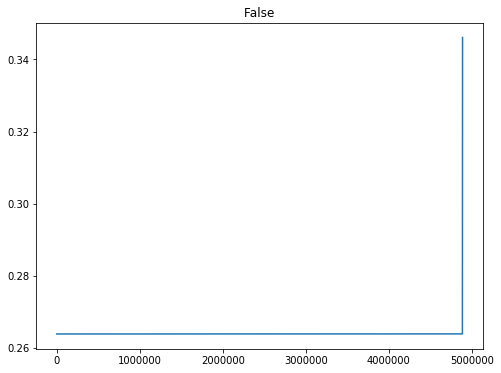

f35-100.mw.dat2 2440.000000000081


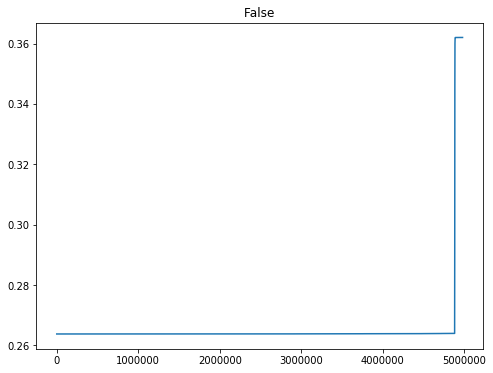

f35-150.mw.dat2 1.9318181817998097


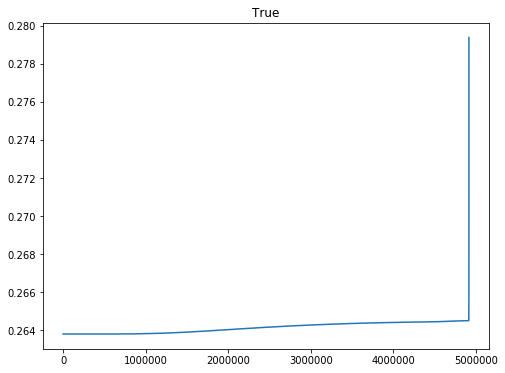

f35-200.mw.dat2 inf


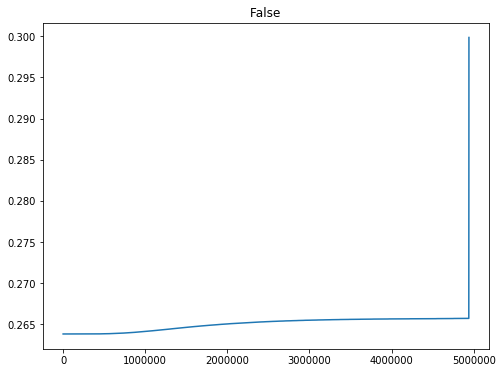

f35-250.mw.dat2 inf


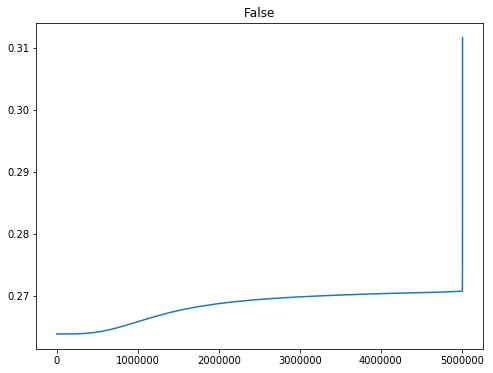

f35-300.mw.dat2 inf


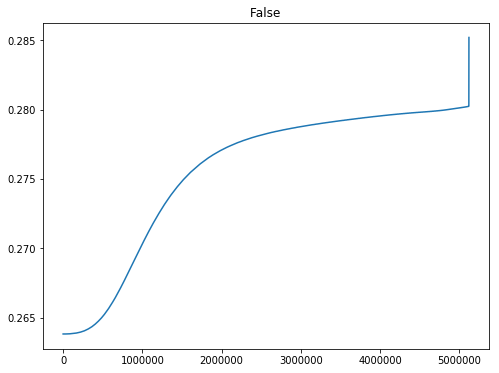

f35-330.mw.dat2 1.0902255639174026


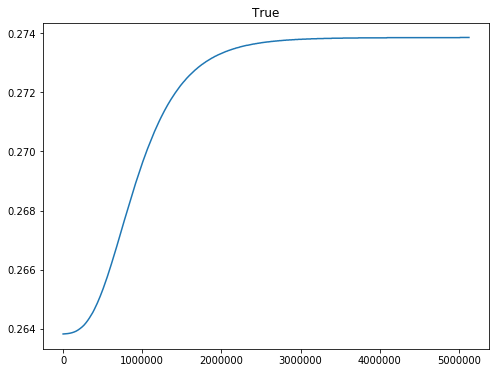

f35-345.mw.dat2 13.333333333297517


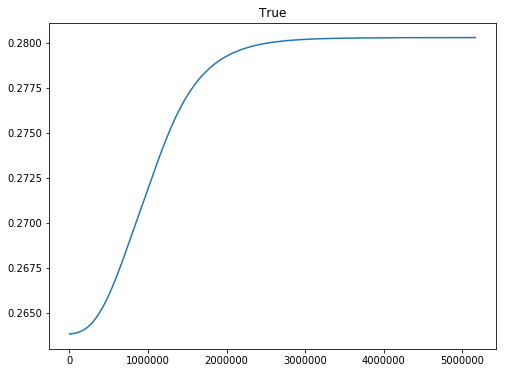

f35-350.mw.dat2 inf


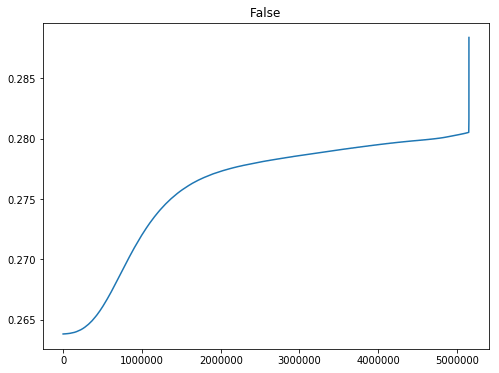

f35-400.mw.dat2 2.504594762947221


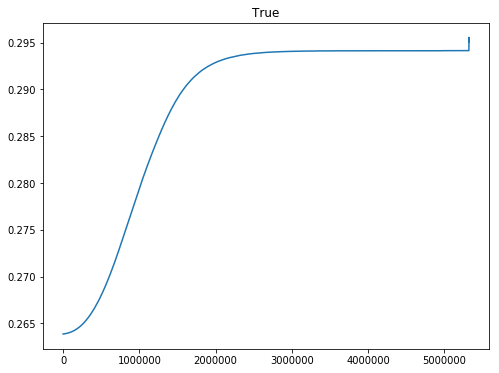

f35-420.mw.dat2 3.5043316104620095


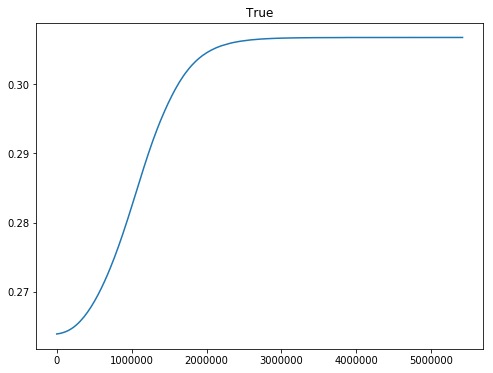

f35-430.mw.dat2 4.852547345450518


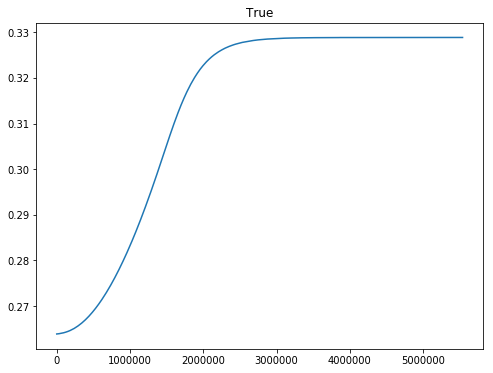

f35-440.mw.dat2 6.116912235150422


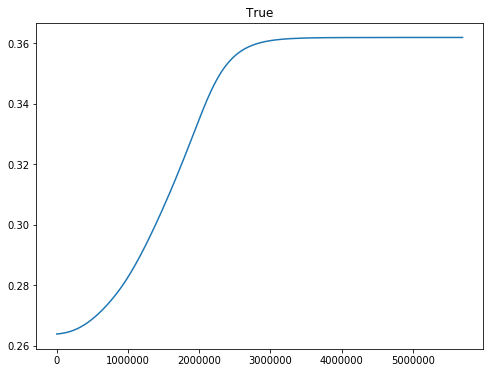

f35-445.mw.dat2 13.333333333340885


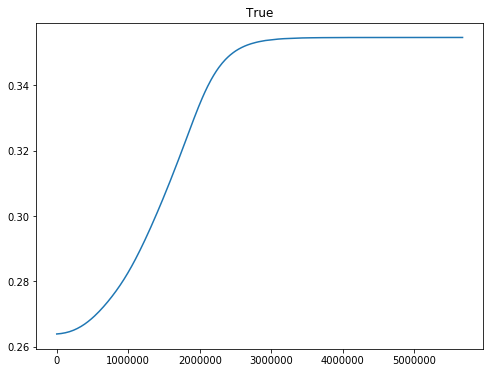

f35-450.mw.dat2 8.148903049044414


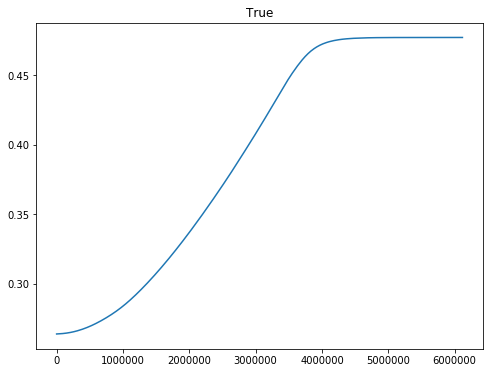

f35-500.mw.dat2 8.320771030178738


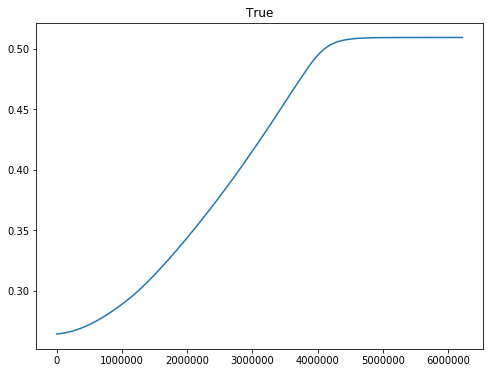

f35-520.mw.dat2 8.416672690880343


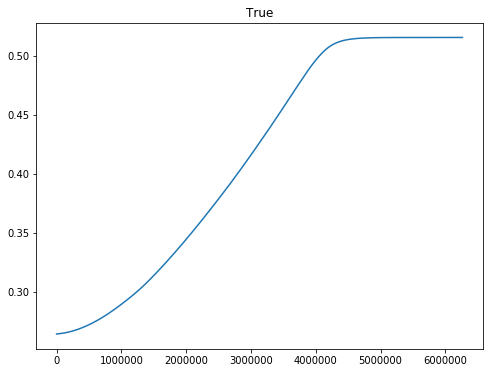

f35-550.mw.dat2 8.73572451503128


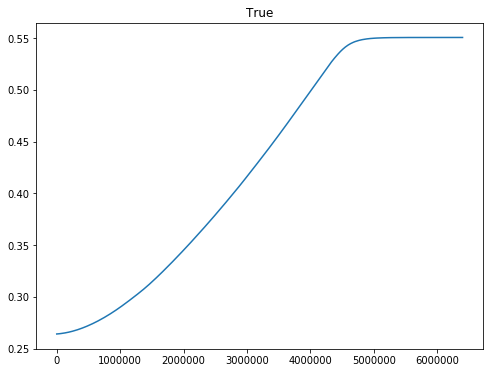

f40-0.mw.dat2 8.673617379884035e-11


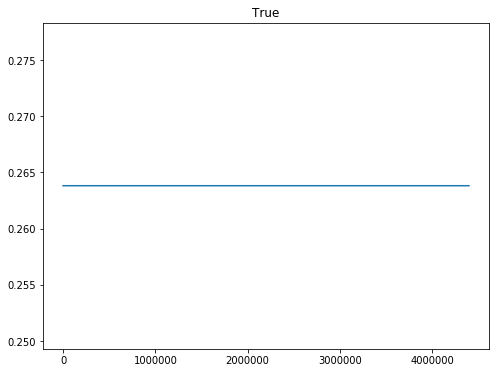

f40-50.mw.dat2 40.00000000019613


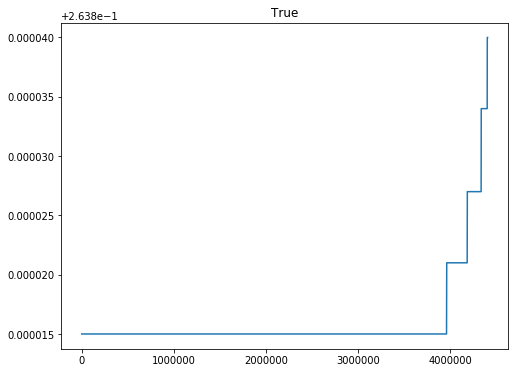

f40-100.mw.dat2 11.428571428627466


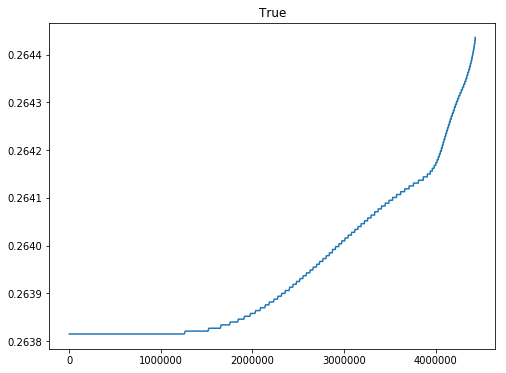

f40-150.mw.dat2 7.636363636397136


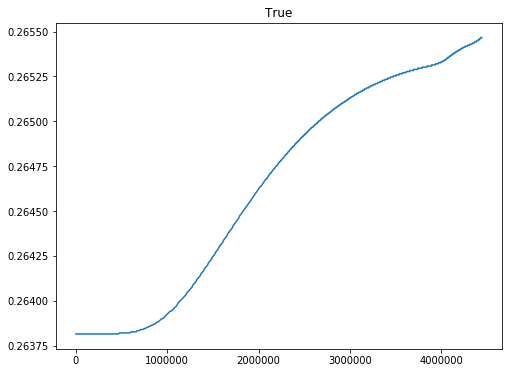

f40-200.mw.dat2 35.00000000031256


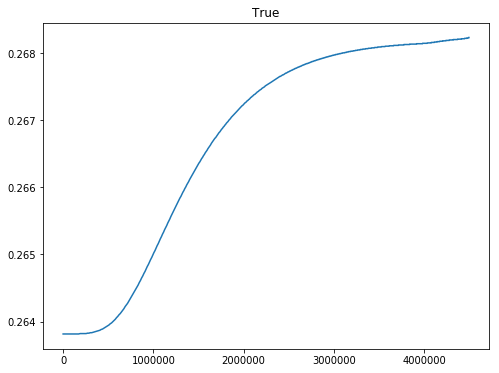

f40-250.mw.dat2 18.000000000066574


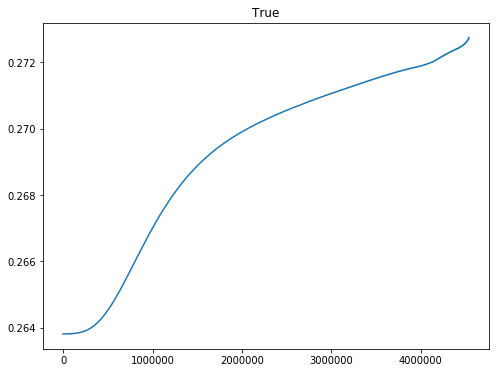

f40-300.mw.dat2 34.99999999979214


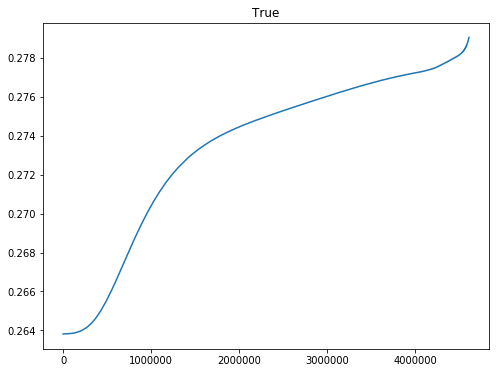

f40-350.mw.dat2 80.00000000008001


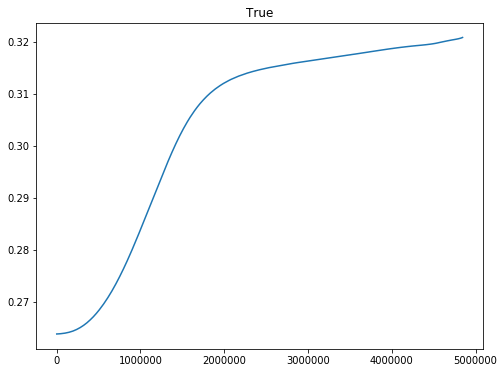

f40-400.mw.dat2 5.890859842121385


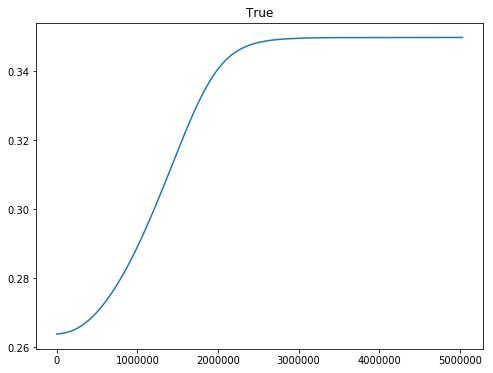

f40-450.mw.dat2 7.919376181379087


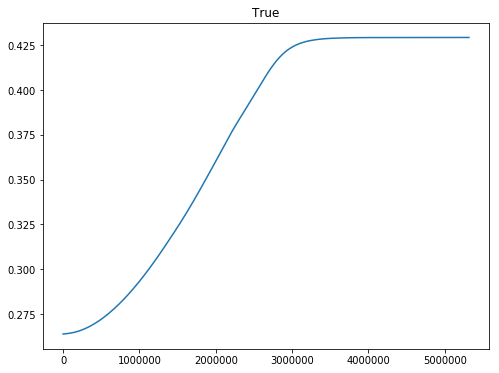

f40-500.mw.dat2 10.042898134194711


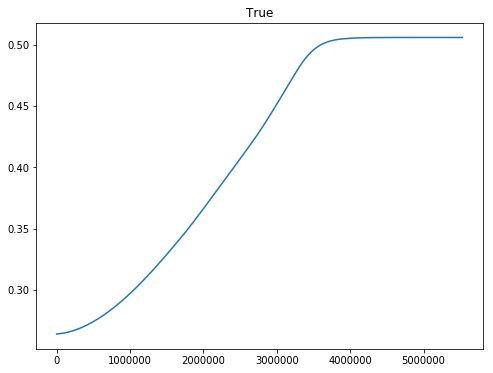

f40-520.mw.dat2 10.056576858938994


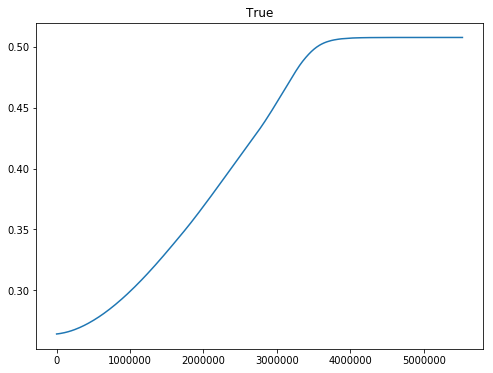

f40-550.mw.dat2 10.25442491884413


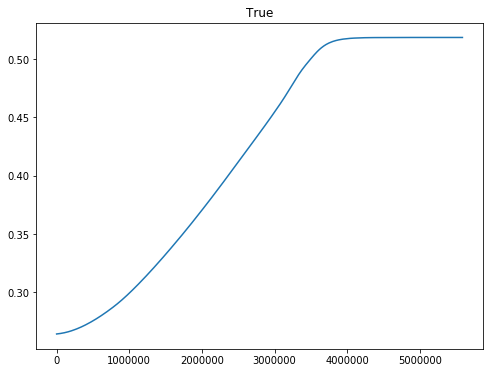

f50-0.mw.dat2 894.9999999998889


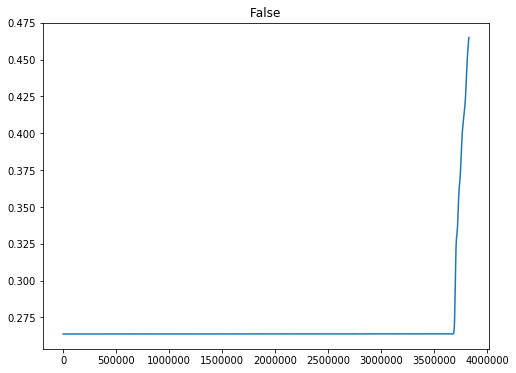

f50-50.mw.dat2 1371.333333332822


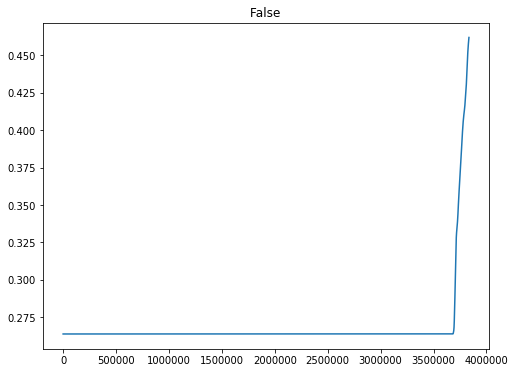

f50-100.mw.dat2 502.5000000000515


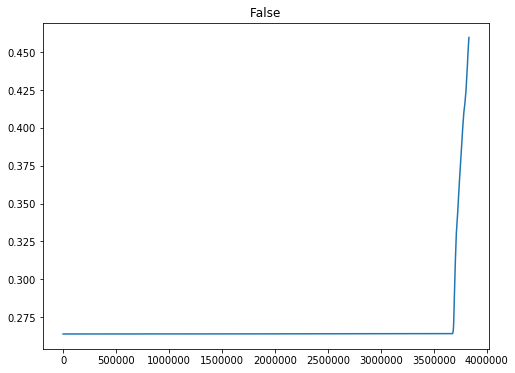

f50-150.mw.dat2 480.00000000001165


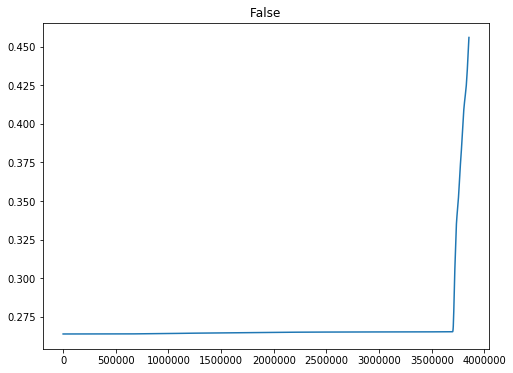

f50-200.mw.dat2 350.00000000000307


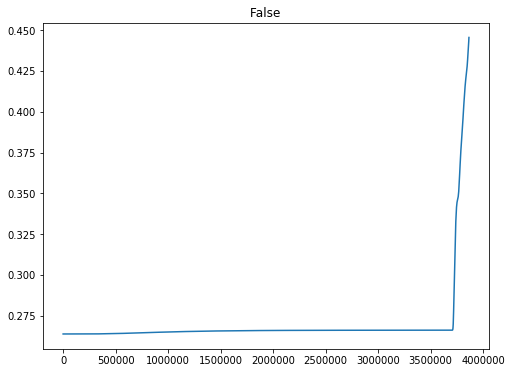

f50-250.mw.dat2 1484.488721804379


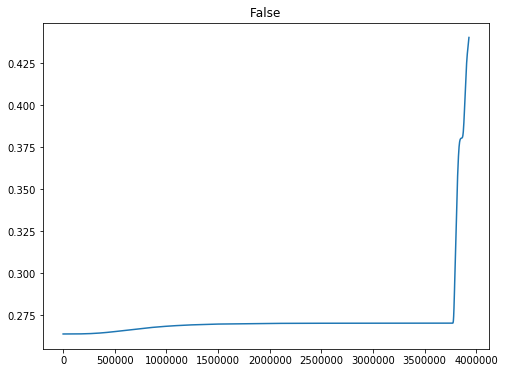

f50-300.mw.dat2 333.39742840443955


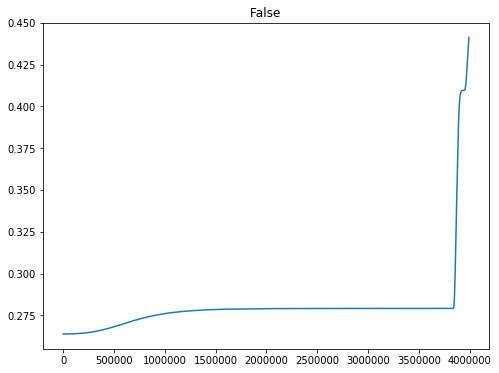

f50-350.mw.dat2 334.1999999999928


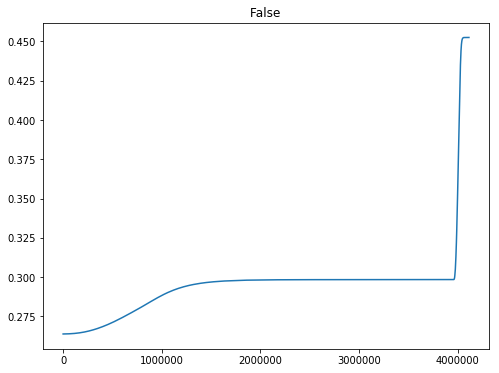

f50-400.mw.dat2 449.99999999999466


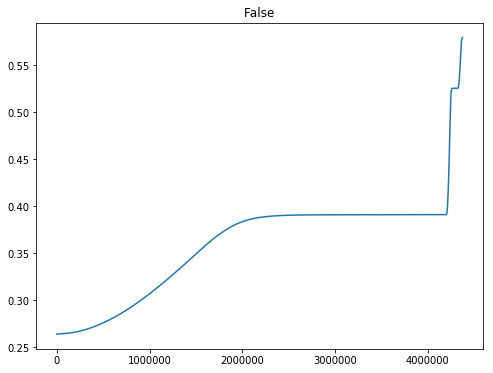

f50-450.mw.dat2 351.89952502737844


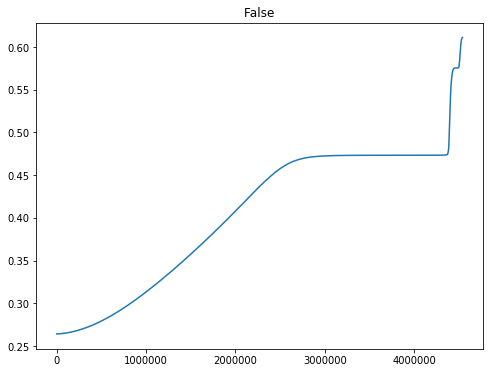

f50-500.mw.dat2 295.2315270935736


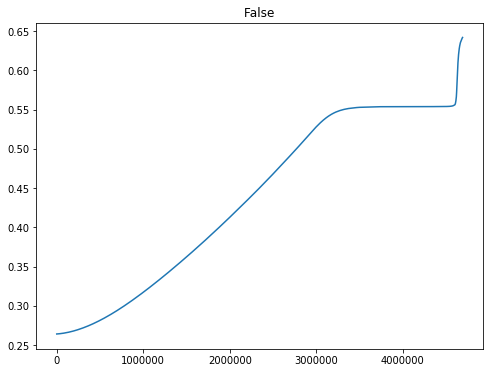

f50-520.mw.dat2 300.0000000000398


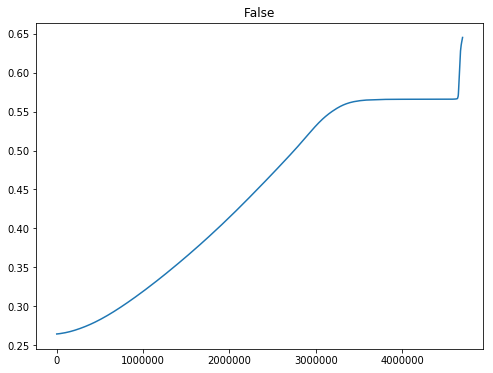

f50-550.mw.dat2 300.083333333416


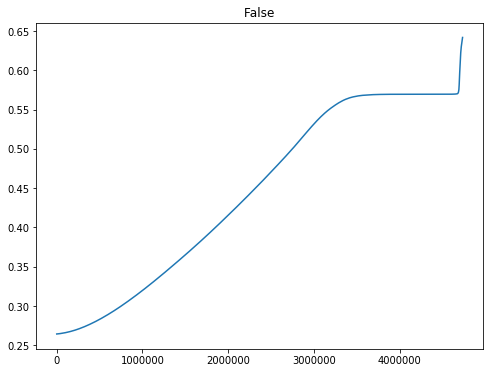

f60-0.mw.dat2 220.72727272745215


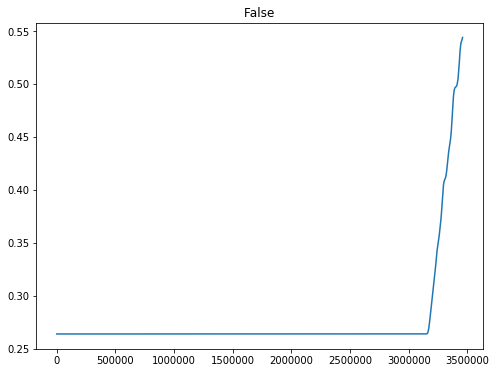

f60-50.mw.dat2 236.78571428569893


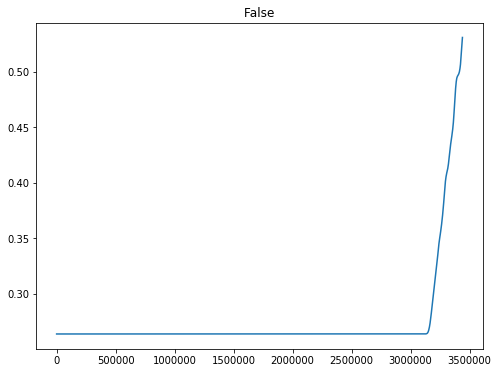

f60-100.mw.dat2 216.1904761906544


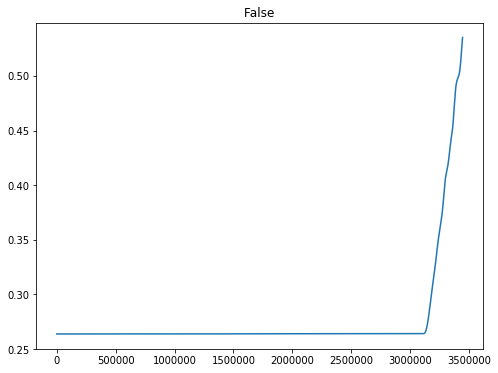

f60-150.mw.dat2 180.47619047608515


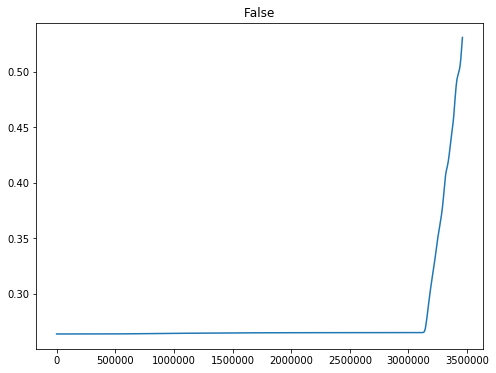

f60-200.mw.dat2 793.3333333335659


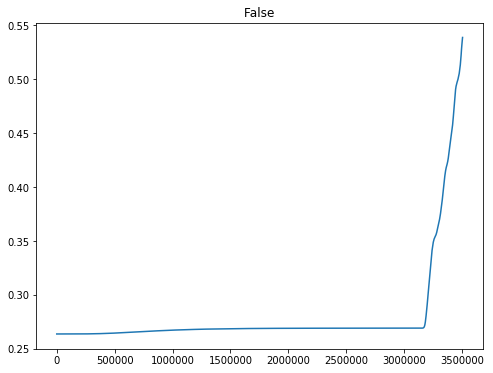

f60-250.mw.dat2 886.0000000002893


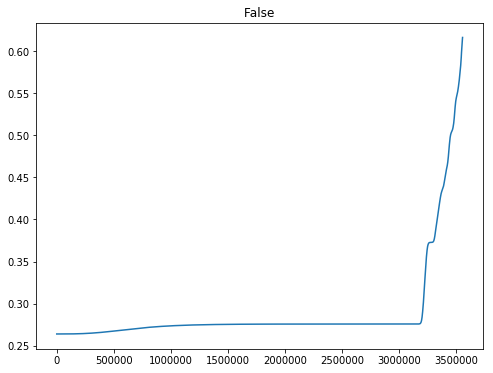

f60-300.mw.dat2 261.99999999999443


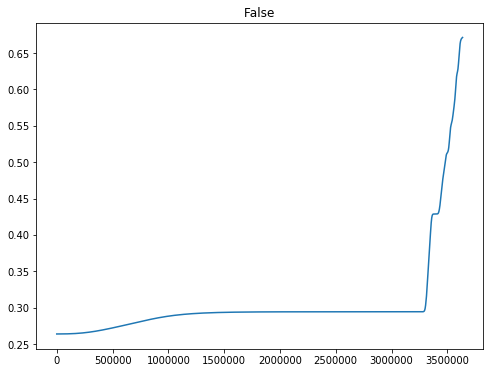

f60-350.mw.dat2 514.3292682926846


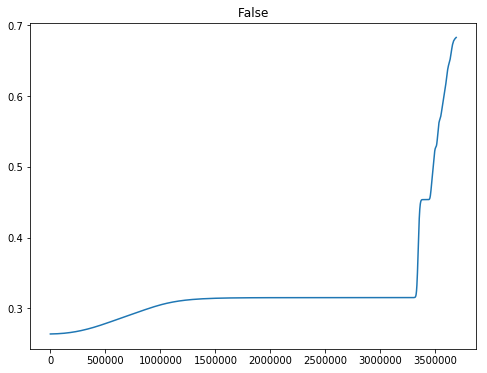

f60-400.mw.dat2 488.01204819277325


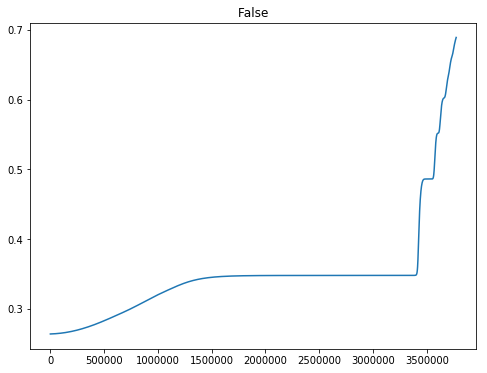

f60-450.mw.dat2 422.30769230768794


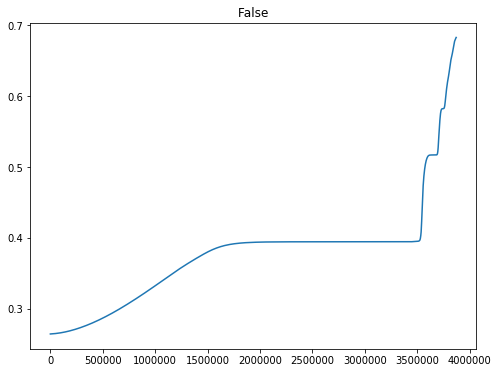

f60-500.mw.dat2 301.1613718217551


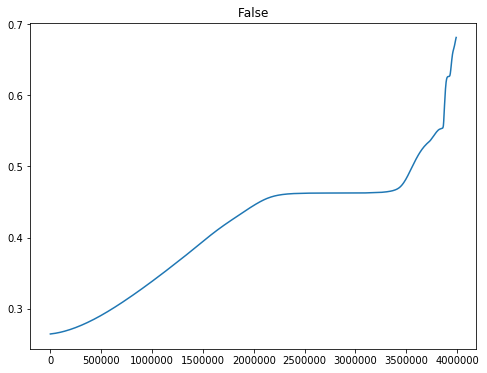

f60-550.mw.dat2 212.619047619024


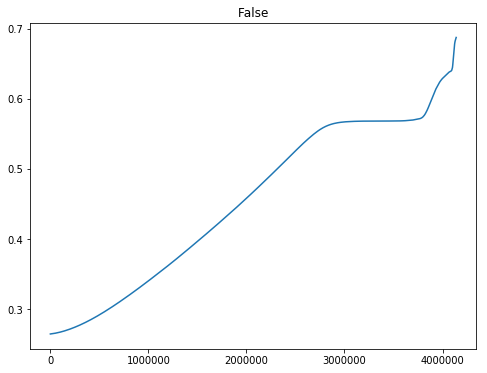

f80-0.mw.dat2 370.00000000023124


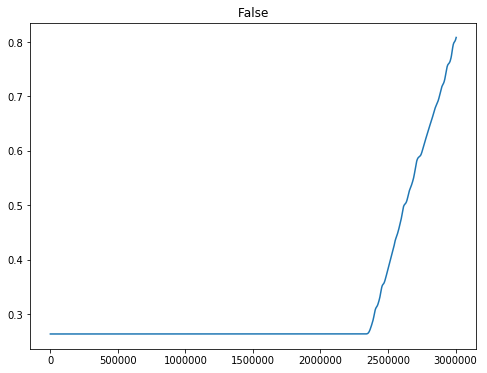

f80-50.mw.dat2 194.28571428579954


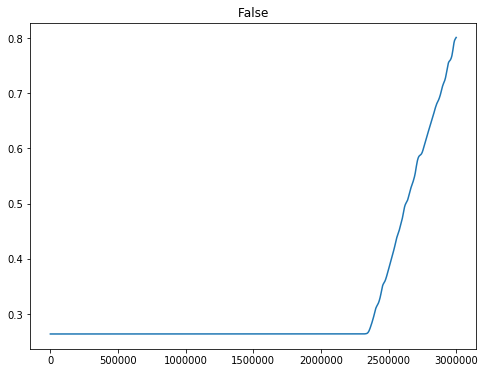

f80-100.mw.dat2 279.99999999972493


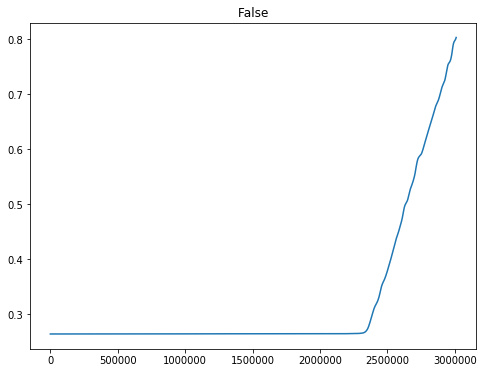

f80-150.mw.dat2 181.3153594772132


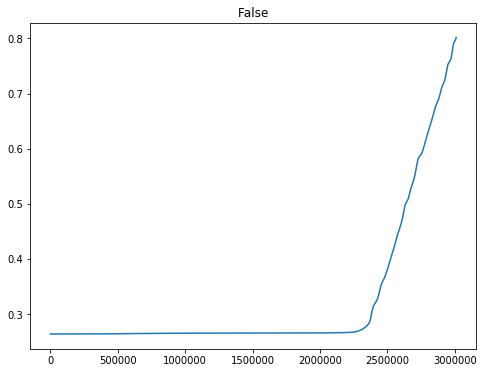

f80-200.mw.dat2 146.98593330171073


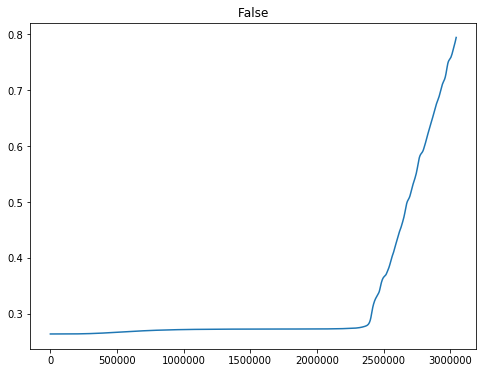

f80-250.mw.dat2 396.66666666743345


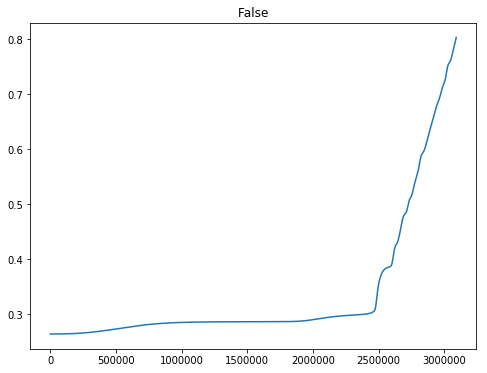

f80-300.mw.dat2 465.00000000018747


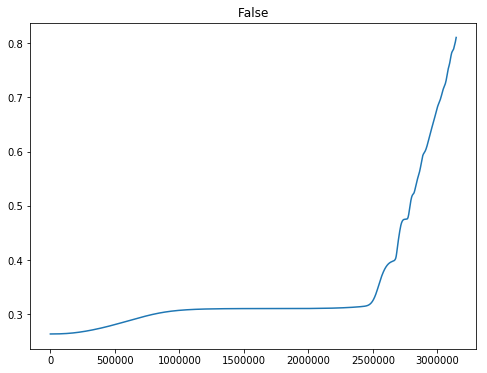

f80-350.mw.dat2 295.30578825669954


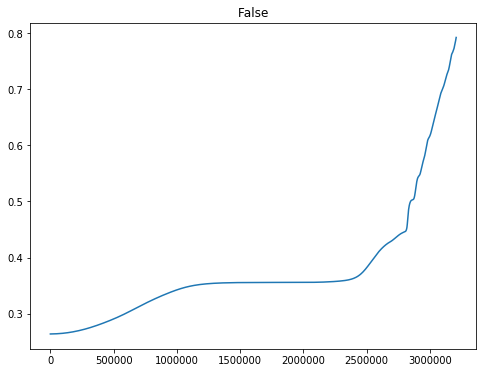

f80-400.mw.dat2 183.52112676057303


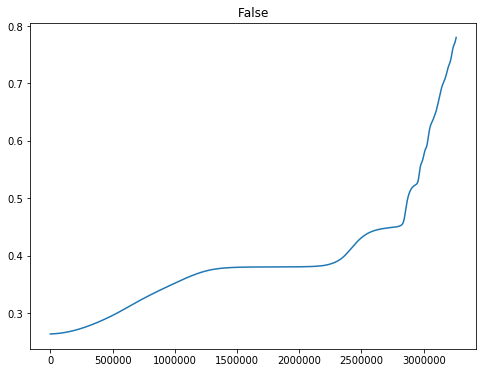

f80-450.mw.dat2 175.7692307692311


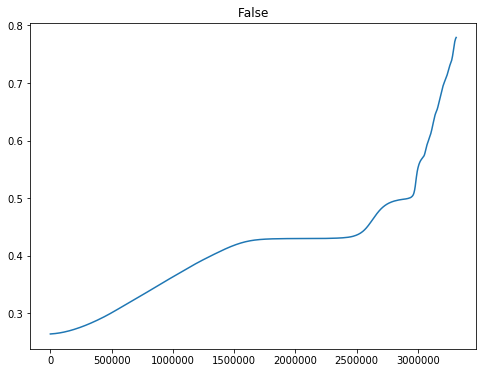

f80-500.mw.dat2 149.24611281350985


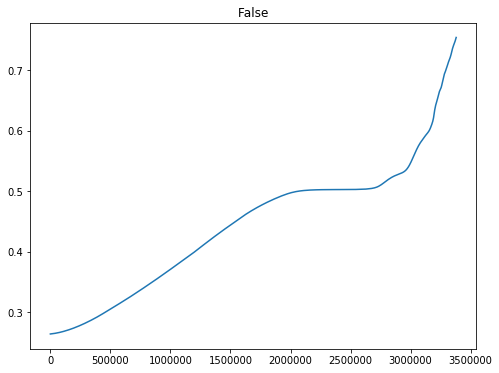

f100-0.mw.dat2 358.33333333311344


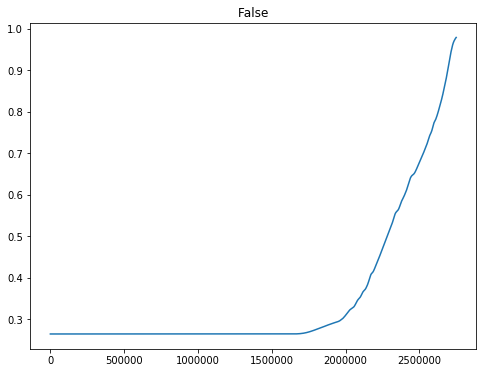

f100-50.mw.dat2 228.63636363629897


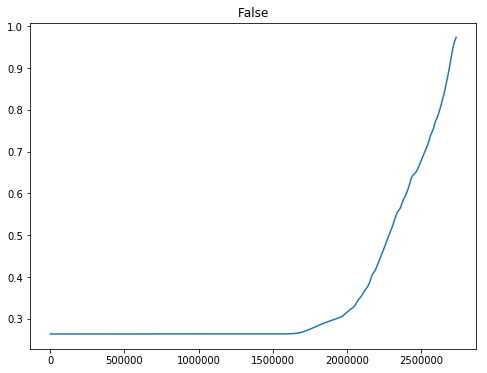

f100-100.mw.dat2 229.55988455992255


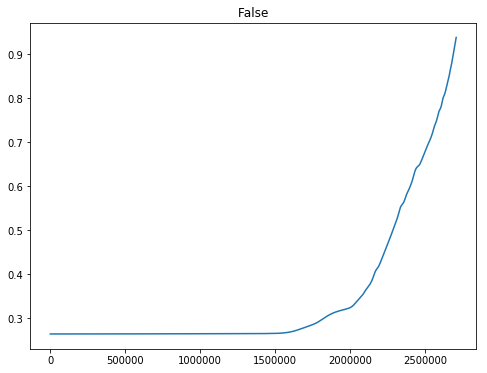

f100-150.mw.dat2 229.91341991351888


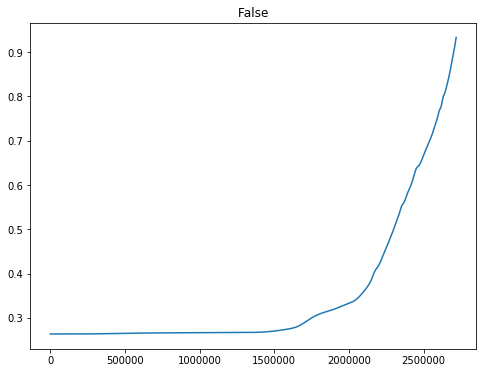

f100-200.mw.dat2 inf


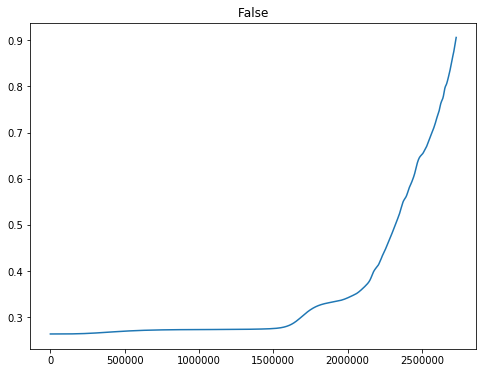

f100-250.mw.dat2 330.0000000011627


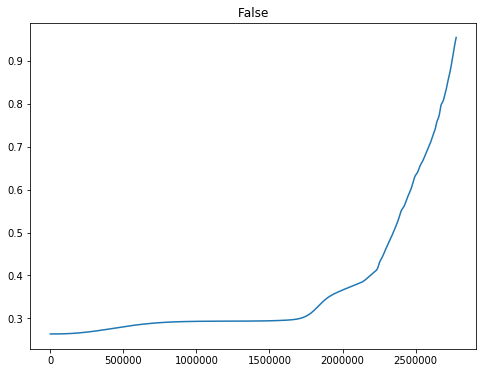

f100-300.mw.dat2 246.42424242410365


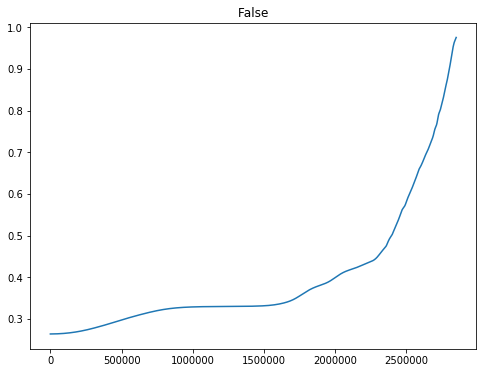

f100-350.mw.dat2 194.1176470588238


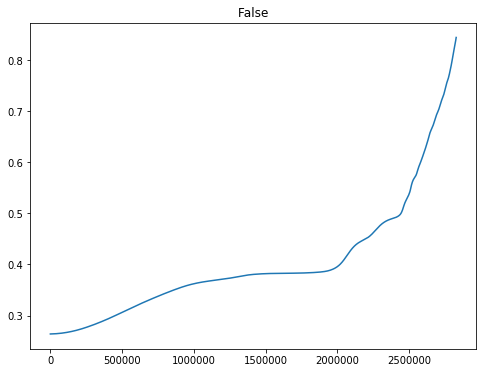

f100-400.mw.dat2 258.6239316235833


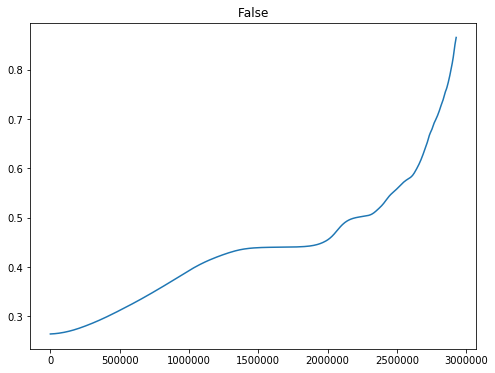

f100-450.mw.dat2 162.81249999999804


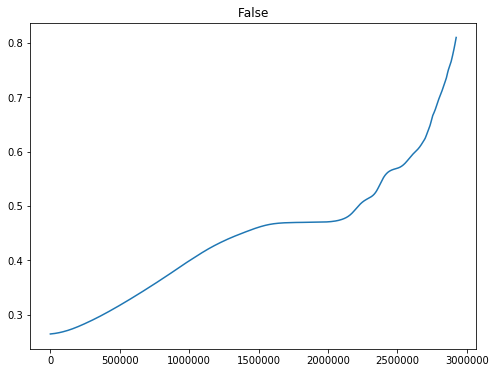

f100-500.mw.dat2 485.0000000007626


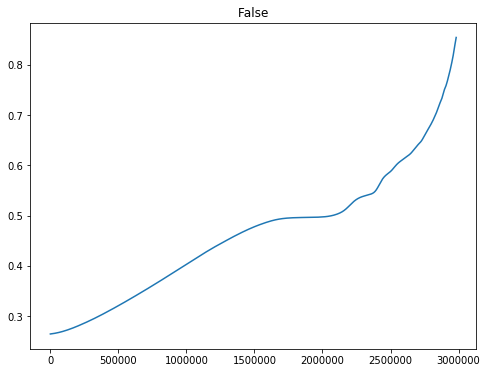

In [64]:
for f in data_files:
    df, _= read_dat2file(f)
    y=np.array(df['27:He_massfr'])
    t=np.array(df['1:t[s]'])

    
    dydt= np.gradient(y, t)
    print f.split('/')[-1], np.nanmax(dydt)/1e-8
    plt.plot(df['1:t[s]'],df['27:He_massfr'], '-')
    plt.title((np.nanmax(dydt)/1e-8) <100)
    plt.show()
    

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for mass_key in mass_list:
    for key in tot_dist.keys():
        if key[0] == mass_key: 
            m=  [mass_key]
            v=  [key[1]]
            z=tot_dist[mass_key, key[1]]



            ax.bar(left=m, height=z, zs=v, zdir='y', color='r', alpha=1)




ax.set_xlabel('m')
ax.set_ylabel('v')
ax.set_zlabel('Z')

plt.show()

In [ ]:
print len(rot_values)

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for  z in ( mass_list):
    
    u=[]
    for key in tot_dist.keys():
        if key[0] == z: 
            #print tot_dist[mass_key, key[1]]
            u.append(tot_dist[mass_key, key[1]])
    
    
    
    xs = rot_values
    ys = np.ones(len(rot_values))

   
    ax.bar(xs, ys, zs=z, zdir='y', alpha=0.8)

ax.set_xlabel('V')
ax.set_ylabel('M')
ax.set_zlabel('Z')

plt.show()